In [1]:
# Required module imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import timeit
from datetime import datetime

notebook_start_time = datetime.now()

In [2]:
# Get directory containing data for each satellite in a satellite specific csv file
individual_sat_data_directory = os.getcwd()
individual_sat_data_directory = os.path.join(individual_sat_data_directory, 'Individual Satellite Data')

In [3]:
def satellite_key(filename):
    '''
    Helper function used by the combine_satellite_data function below.
    
    Argument:
    filename -- file name with the satellite name preceding the .csv extension, for example alpha.csv
    
    Returns:
    name of the satellite based on the correponsing csv file with the same name.
    '''
    return filename.split('.')[0]


def average_across_columns(data, column_groups, new_column_names, method=None):
    '''
    Implements the averaging procedure to calculate the average across multiple telemetry channels. 
    
    Arguments: 
    data -- data containing all telemetry channels for all satellites concatenated row-wise
    column_groups -- 2D list of strings. First dimension contains groups of channels to be averaged. The second dimension
                     contains the channels across which the averaging will be performed. For example, if 
                     column_groups = [[gyro_x, gyro_y], [wheel_x, wheel_y]], then this means two groups are to be averaged, 
                     i.e, calculating average of gyro_x and gyro_z and average of wheel_x and wheel_y.
    new_column_name -- 1D list of desired column names containing the calculated average. 
    method -- a 2D list of flags indicating whether elements with value of 0 are to be part of the average or not. None means 0 
              values will be part of average and 'active_only' means only elements that are NOT zero will be part of the 
              average
    
    Returns:
    dataframe containing column names passed via new_column_name argument.
    '''
    #Initialize empty list which will contain data for the averages
    mean_data = []
    
    #Initialize array of None for compatability with the calculation procedure
    if not method:
        method = [None for i in range(len(column_groups))]
    
    for i in range(len(column_groups)):    
        if method[i] == 'active_only':
            frame_for_average = data[column_groups[i]] #Select columns from the dataframe required for calculation 
            frame_for_average = frame_for_average[frame_for_average[column_groups[i]] != 0] #Filter values that are 0
            mean_data.append(frame_for_average[column_groups[i]].abs().mean(axis=1)) #Averaging calculation

        else:
            mean_data.append(data[column_groups[i]].abs().mean(axis=1))
    
    mean_dataframe = pd.DataFrame(dict(zip(new_column_names, mean_data))) #concatenate two Series in to a dataframe
    
    return mean_dataframe

In [31]:
def combine_satellite_data(individual_sat_data_directory, method=None):
    '''
    Implements the procedure to combine data for all satellites from different csv files in to one dataframe for ease of 
    accessing the data later. This does not parse data from the file containing the beta angle for all satellites.
    
    Arguments:
    individual_sat_data_directory -- directory containing data for each of the seven satellites
    method -- variable used to call average_across_columns function. See the description of this variable in 
              average_across_columns function
    
    Returns
    satellite_data -- pandas dataframe containing data for all 7 satellites concatenated row-wise.
    sat_id_data -- dictionary containing dataframe indexing information for accessing a particular satellite's data in the 
                   satellite_data array. For example, if sat_id_data['bravo']=[703415, 1159266], it means data for bravo starts 
                   at index 703415 and ends at index 1159265
    '''
    
    satellite_data = []
    sat_id_data = dict()
    total_length = 0
    for i in os.listdir(individual_sat_data_directory): #Read data from each satellite file in a loop
        filename = os.path.join(individual_sat_data_directory, i)
        data = pd.read_csv(filename)
        data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms') #Convert epoch timestamp to a comprehensible datetime format
        
        sat_id_data[satellite_key(i)] = [total_length, total_length+data.shape[0]] #Calculate index information 
        total_length += data.shape[0]
        
        satellite_data.append(data)
    
    #Concatenate all 7 dataframes row-wise in to one big dataframe
    satellite_data = pd.concat(satellite_data, ignore_index=True)
    
    gyro_means = ['gyro_x', 'gyro_y', 'gyro_z'] #Add the column containing average of gyro_x, gyro_y and gyro_z to the dataframe. These are hardcorded here for repetitive use.
    wheel_means = ['wheel_s', 'wheel_x', 'wheel_y', 'wheel_z']#Add the column containing average of the four wheels to the dataframe. These are hardcorded here for repetitive use.
    
    #concatenate calculated averages for gyros and wheels to the satellite_data 
    satellite_data = pd.concat([satellite_data, average_across_columns(satellite_data,
                                                                       column_groups=[gyro_means, wheel_means],
                                                                       new_column_names=['gyro_mean', 'wheel_mean'],
                                                                       method=method)], axis=1)
    return satellite_data, sat_id_data

In [5]:
def violin_graph(data_array, column_groups, plots_per_row = 2,
                 axes_labels=None, filename='filename', title='Satellite'):
    '''
    Implements a function to create violin graphs for a variety of presentation styles and saves them as a .png file @ 300 dpi
    
    Argument:
    data_array -- data containing all telemetry channels. Data could be for one or any number of satellites
    column_groups -- 2D list. Each of the entries in the first dimension contain data for each subplot
    plots_per_row -- number of plots to show per row
    axes_labels -- 2D list. Each of the entries in the first dimension contain axes labes for each subplot
    filename -- filename for the saved figure. Default is 'filename'
    title -- main title of the figure. Default is 'Satellite'
       
    '''
    
    num_of_plots = len(column_groups)
    subplot_columns = plots_per_row
    if len(column_groups)%subplot_columns:
        fig, axs = plt.subplots(figsize=(15,7.5), squeeze=False)
    else:
        fig, axs = plt.subplots(num_of_plots//subplot_columns, subplot_columns, figsize=(22.5,7.5), squeeze=False)
     
    fig.suptitle(title, fontsize=20)
    x_label = y_label = None
    
    for i in range(num_of_plots):
        data = data_array[i]
        row_loc = (i)//subplot_columns
        col_loc = int(i % subplot_columns)
        labels = column_groups[i]
        
        if axes_labels:
            x_label = axes_labels[i][0]
            y_label = axes_labels[i][1]
            
        x_ticks = list(range(1, len(labels)+1))
        q=[0.25,0.75]
        plot = axs[row_loc, col_loc].violinplot([data[label] for label in labels],
                                                vert=True, showmedians=True, quantiles=[q]*len(labels))
        plot['cmedians'].set_color('r')
        plot['cquantiles'].set_color('y')
        plot['cmins'].set_color('g')
        plot['cmaxes'].set_color('g')
        axs[row_loc, col_loc].set_xticks(x_ticks)
        axs[row_loc, col_loc].set_xticklabels(labels)
        axs[row_loc, col_loc].set_xlabel(x_label)
        axs[row_loc, col_loc].set_ylabel(y_label)
        axs[row_loc, col_loc].grid(True, axis='y')
        custom_legends = [Line2D([0], [0], color='r', lw=2),
                          Line2D([0], [0], color='y', lw=2),
                          Line2D([0], [0], color='g', lw=2)]
        axs[row_loc, col_loc].legend(custom_legends, ['median', '1st and 3rd quartile', 'min, max'])
        
#     fig.savefig(filename+'.png', dpi=300)
#     plt.close(fig)

In [6]:
def xy_plots(data_array, columns, plots_per_row=2,
             axes_labels=None, filename='filename', title=None, x_axis='timestamp', plot_type='line'):
    
    '''
    Implements a function to create line or scatter graphs for a variety of presentation styles and saves them as a .png file 
    @ 300 dpi
    
    Argument:
    data_array -- data containing all telemetry channels. Data could be for one or any number of satellites
    columns -- 2D list. Each of the entries in the first dimension contain data for each subplot
    plots_per_row -- number of plots to show per row
    axes_labels -- 2D list. Each of the entries in the first dimension contain axes labes for each subplot
    filename -- filename for the saved figure. Default is 'filename'
    title -- main title of the figure. Default is 'Satellite'
    x_axis -- column of data_array to be used as x-axis
    plot_type -- one of two allowable types, line or scatter
       
    '''
    
    num_of_plots = len(columns)
    subplot_columns = plots_per_row
    if len(columns)%subplot_columns:
        fig, axs = plt.subplots(figsize=(15,7.5), squeeze=False)
    else:
        fig, axs = plt.subplots(num_of_plots//subplot_columns, subplot_columns, figsize=(22.5,7.5), squeeze=False)
     
    fig.suptitle(title, fontsize=20)
        
    x_label = y_label = None
    for i in range(num_of_plots):
        data = data_array[i]
        row_loc = (i)//subplot_columns
        col_loc = int(i % subplot_columns)
        if axes_labels:
            x_label = axes_labels[i][0]
            y_label = axes_labels[i][1]
        
        if plot_type == 'line':
            for y in (columns[i]):
                axs[row_loc, col_loc].plot(data[x_axis], data[y], label=y)

        elif plot_type == 'scatter':
            for y in (columns[i]):
                axs[row_loc, col_loc].scatter(data[x_axis], data[y], label=y)

        else:
            raise('Provide a valid plot type')
            
        axs[row_loc, col_loc].set_xlabel(x_label)
        axs[row_loc, col_loc].set_ylabel(y_label)
        axs[row_loc, col_loc].grid(True, axis='y')
        axs[row_loc, col_loc].legend()
        
#     fig.savefig(filename+'.png', dpi=300)
#     plt.close(fig)

#### Question 1: Develop a Python script that is able to retrieve all the data from the CSV files, filter the data to make it presentable and plot the following (attach also the graphs):

In [7]:
'''
Use the function above to create a dataframe containing data for all satellites. 
Note: All the subsequents snippets of code use sort of some slicing of this array. This is not a very scalable approach due to the time complexity of slicing an array which is O(k). A much more scalable and faster way to do this is to have a dictionary containing the dataframe for each satellite as a value and the key being the satellite name itself. One minor drawback of having the dataframe in a dictionary format is that an extra dataframe with data for all satellites combined would also be required to avoid concatenation in situations where plotting for all satellites is required on one graph. Either ways, the size of the data is not that large here so the current approach of array slicing doesn't hurt much.
'''
then = datetime.now()
data, sat_id_data = combine_satellite_data(individual_sat_data_directory, method=[None, None])
datetime.now()-then

datetime.timedelta(seconds=6, microseconds=219979)

In [29]:
data.head()

,timestamp,gyro_x,gyro_y,gyro_z,wheel_s,wheel_x,wheel_y,wheel_z,low_voltage,bus_voltage,gyro_mean,wheel_mean
0,2019-05-30 10:00:00.125,-0.106707,0.053354,-0.102896,1400.0,2200.0,3200.0,3100.0,NaN,NaN,0.087652,2475.0
1,2019-05-30 10:00:00.171,-0.106707,0.053354,-0.102896,NaN,NaN,NaN,NaN,NaN,NaN,0.087652,NaN
2,2019-05-30 10:00:00.271,-0.068598,-0.022866,-0.121951,NaN,NaN,NaN,NaN,NaN,NaN,0.071138,NaN
3,2019-05-30 10:00:00.371,-0.198171,0.015244,-0.114329,NaN,NaN,NaN,NaN,NaN,NaN,0.109248,NaN
4,2019-05-30 10:00:00.471,-0.087652,-0.003811,-0.194360,NaN,NaN,NaN,NaN,NaN,NaN,0.095274,NaN


#### 1a: All the telemetry channels of each satellite in a single page (all gyros and wheels together)

Time to Filter Data for alpha is 0:00:00.201073
Time to Create Graphs for alpha is 0:00:21.345471

Time to Filter Data for bravo is 0:00:00.115920
Time to Create Graphs for bravo is 0:00:13.096068

Time to Filter Data for charlie is 0:00:00.250325
Time to Create Graphs for charlie is 0:00:21.401604

Time to Filter Data for delta is 0:00:00.230867
Time to Create Graphs for delta is 0:00:15.876037

Time to Filter Data for echo is 0:00:00.069057
Time to Create Graphs for echo is 0:00:05.697488

Time to Filter Data for foxtrot is 0:00:00.221458
Time to Create Graphs for foxtrot is 0:00:21.391906

Time to Filter Data for golf is 0:00:00.242216
Time to Create Graphs for golf is 0:00:19.670046



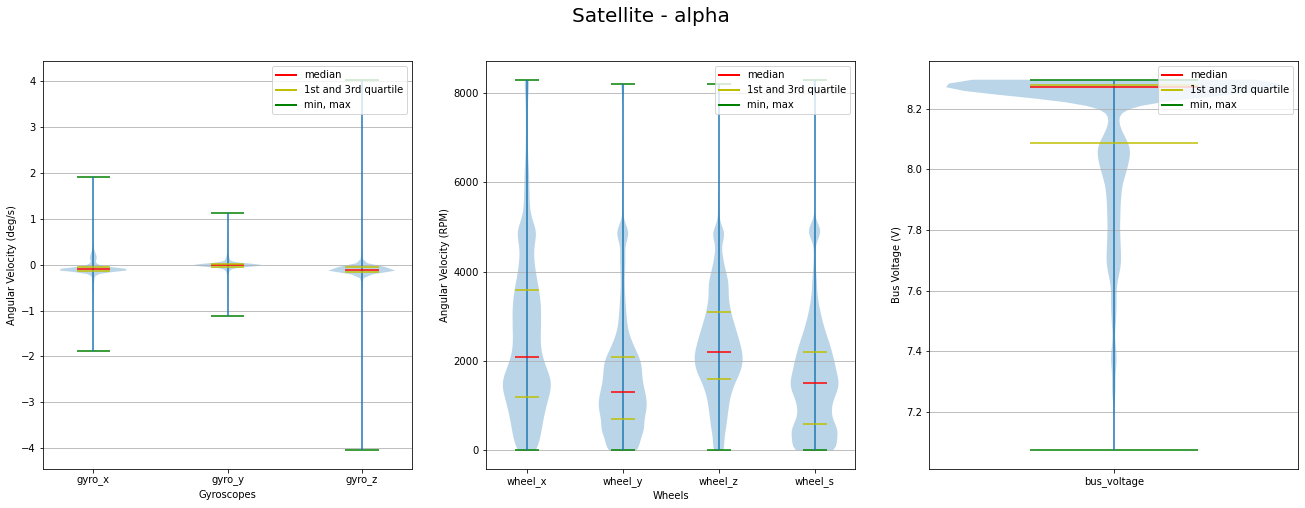

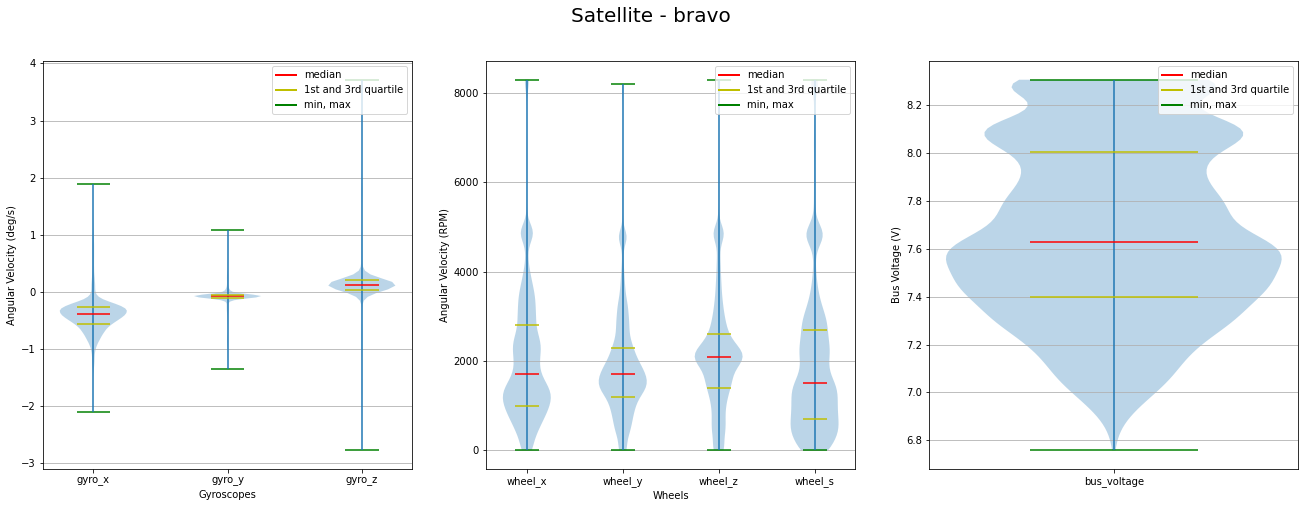

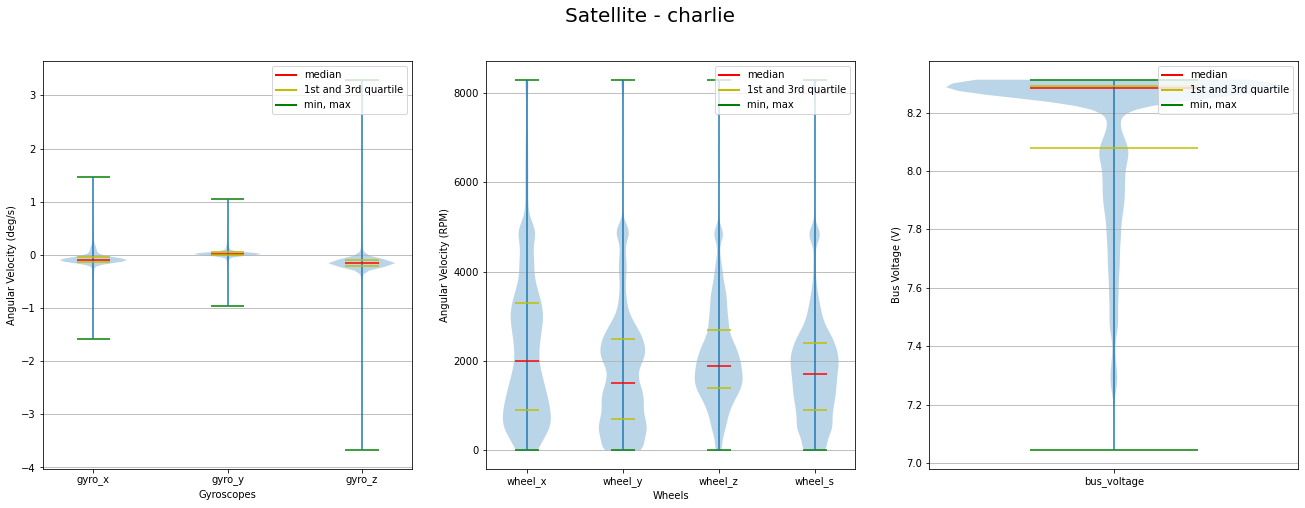

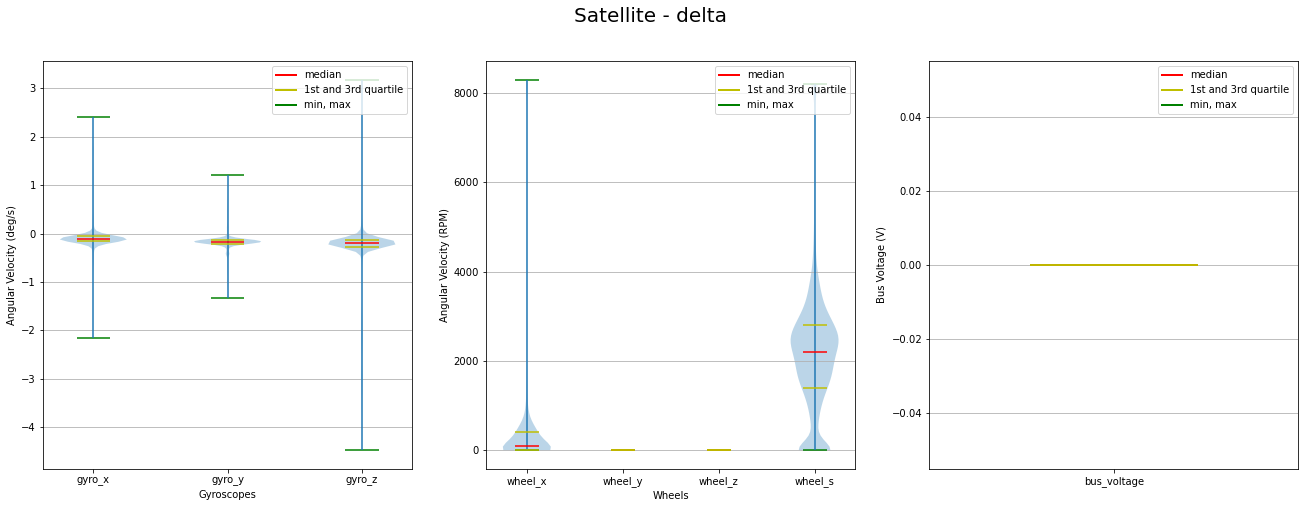

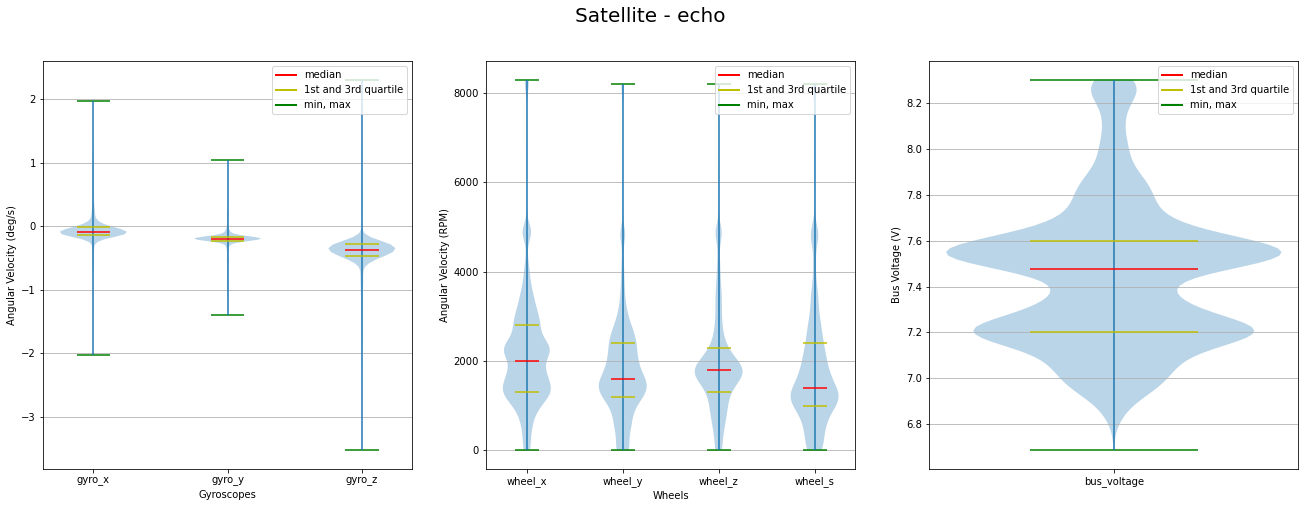

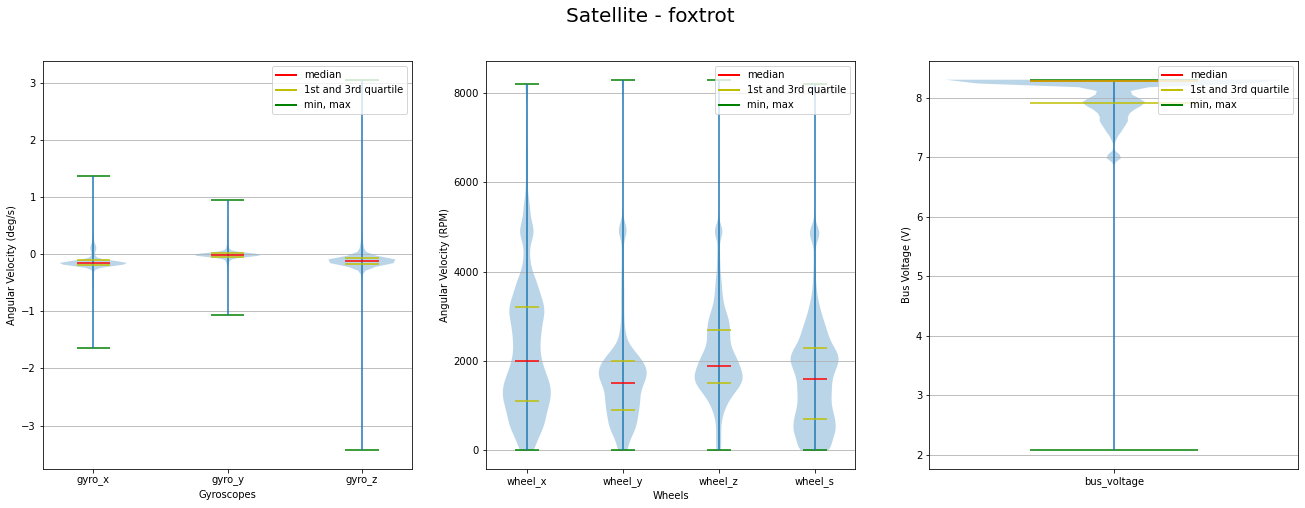

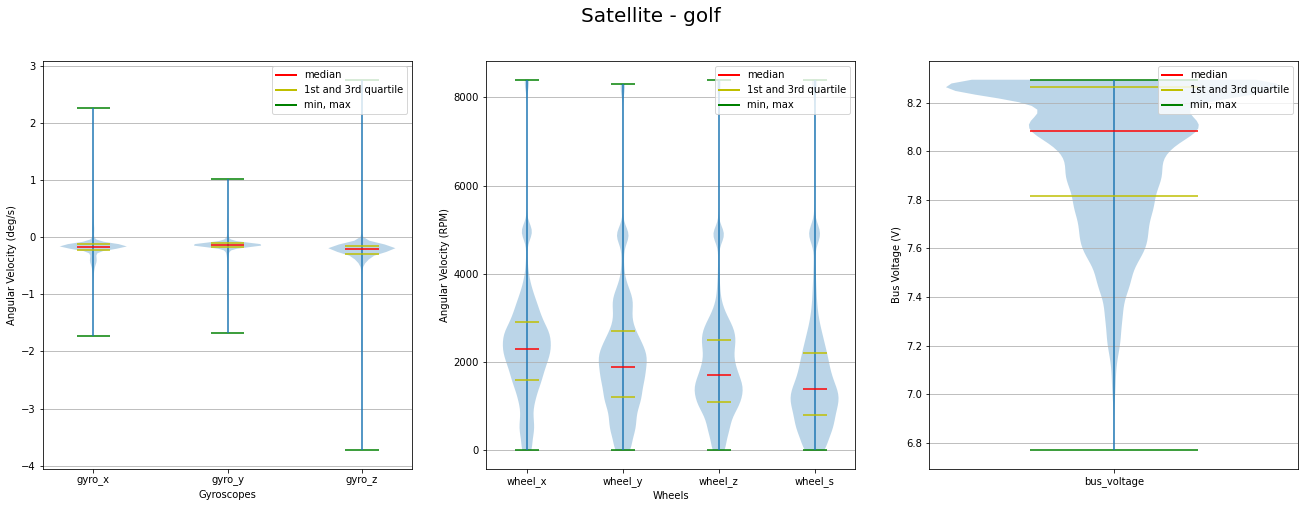

In [8]:
# This creates violin graphs for each of the seven satellites. 
folder = 'Violinplots'
for satellite in sat_id_data:
    time_filter_0 = datetime.now()
    plot1, plot1_axis = ['gyro_x', 'gyro_y', 'gyro_z'], ('Gyroscopes', 'Angular Velocity (deg/s)')#Subplot1
    plot2, plot2_axis = ['wheel_x', 'wheel_y', 'wheel_z', 'wheel_s'], ('Wheels', 'Angular Velocity (RPM)')#Subplot2
    plot3, plot3_axis = ['bus_voltage'], ('', 'Bus Voltage (V)')#Subplot3
    curr_sat_data = data.iloc[sat_id_data[satellite][0]:sat_id_data[satellite][1], :] #Slice the dataframe to get individual satellite data. Again, not the most efficient way to get data this way but it doesn't hurt much here due to the relatively small size of data
    gyro_data = curr_sat_data[curr_sat_data.gyro_x.notna()] #Filter the array for to get only non NaN gyro values
#     gyro_data = gyro_data[gyro_data.wheel_s.notna()]##
    wheel_data = curr_sat_data[curr_sat_data.wheel_s.notna()]  #Filter the array for to get only non NaN wheel values
    voltage_data = curr_sat_data[curr_sat_data.bus_voltage.notna()] #Filter the array for to get only non NaN voltage values
    
    time_filter_1 = datetime.now() - time_filter_0
    print(f'Time to Filter Data for {satellite} is {time_filter_1}')
    #Create violin using the helper function above
    violin_graph([gyro_data, wheel_data, voltage_data], column_groups=[plot1, plot2, plot3], plots_per_row=3,
                 axes_labels=[plot1_axis, plot2_axis, plot3_axis], 
                 filename=f'./Q1a/{folder}/{satellite}', title=f'Satellite - {satellite}')

    time_filter_2 = (datetime.now() - time_filter_0) - time_filter_1
    print(f'Time to Create Graphs for {satellite} is {time_filter_2}\n')

Time to Filter Data for alpha is 0:00:00.364522
Time to Create Graphs for alpha is 0:00:00.473337

Time to Filter Data for bravo is 0:00:00.141462
Time to Create Graphs for bravo is 0:00:00.314970

Time to Filter Data for charlie is 0:00:00.223397
Time to Create Graphs for charlie is 0:00:00.498100

Time to Filter Data for delta is 0:00:00.294107
Time to Create Graphs for delta is 0:00:00.514598

Time to Filter Data for echo is 0:00:00.069068
Time to Create Graphs for echo is 0:00:00.214060

Time to Filter Data for foxtrot is 0:00:00.202026
Time to Create Graphs for foxtrot is 0:00:00.432210

Time to Filter Data for golf is 0:00:00.191756
Time to Create Graphs for golf is 0:00:00.401418



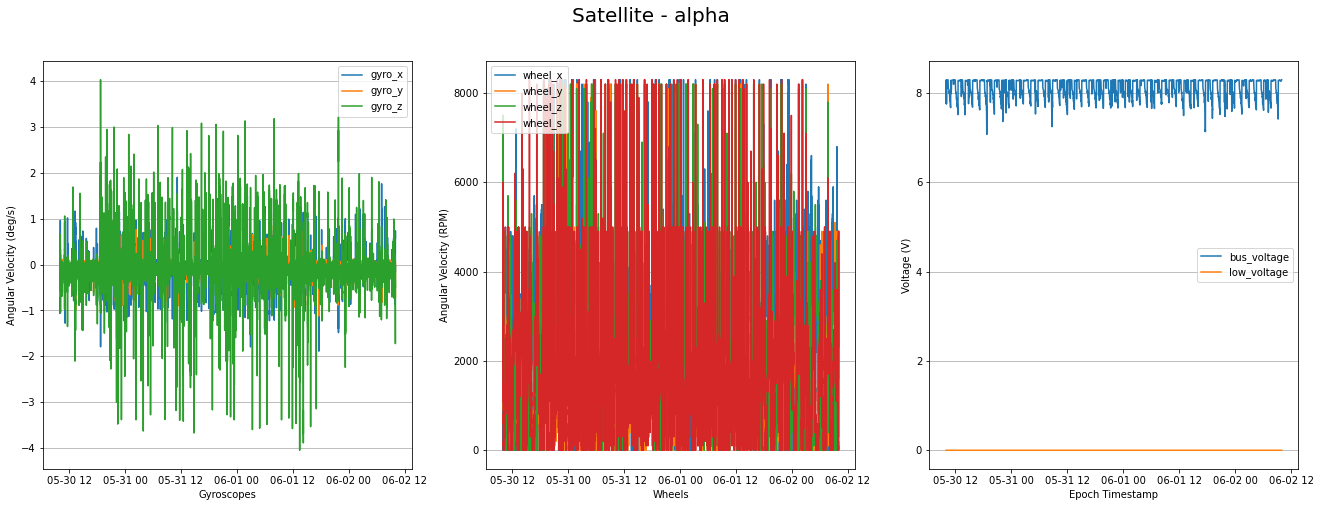

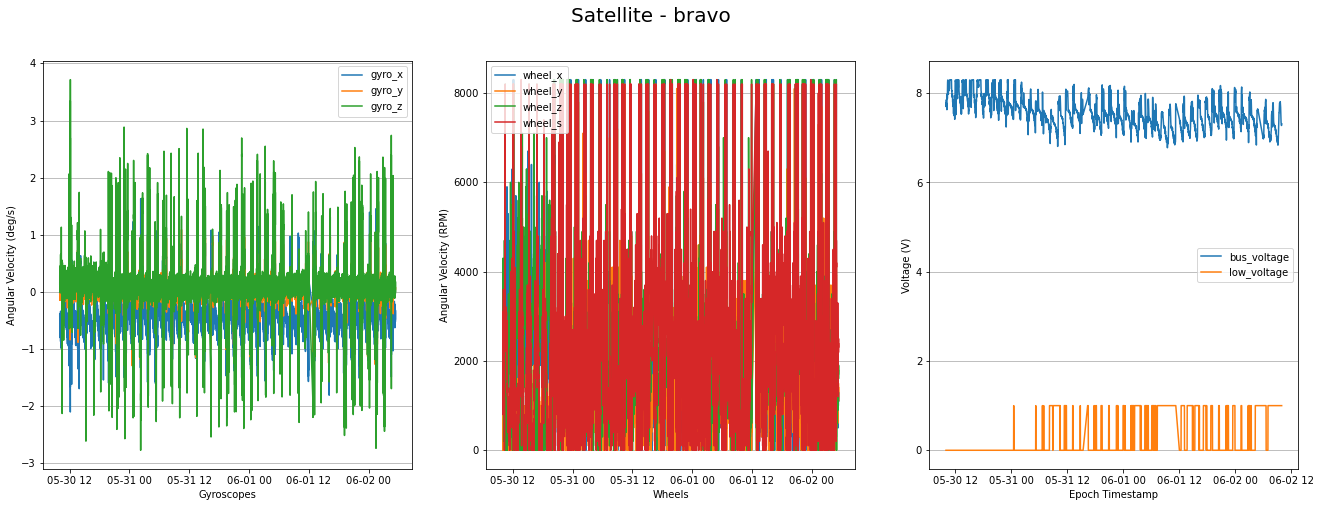

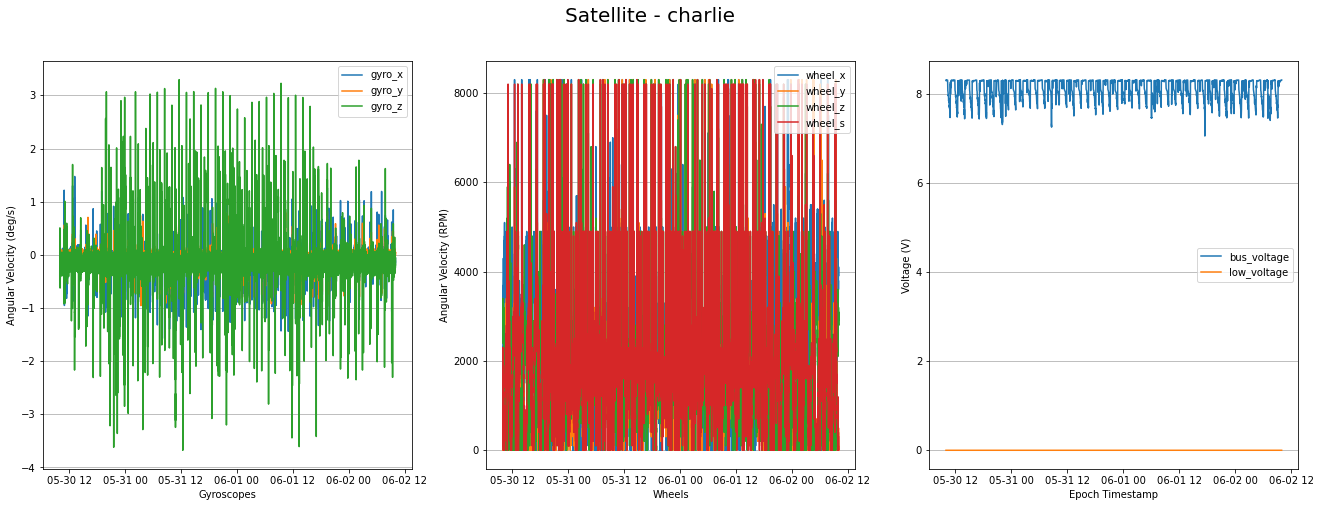

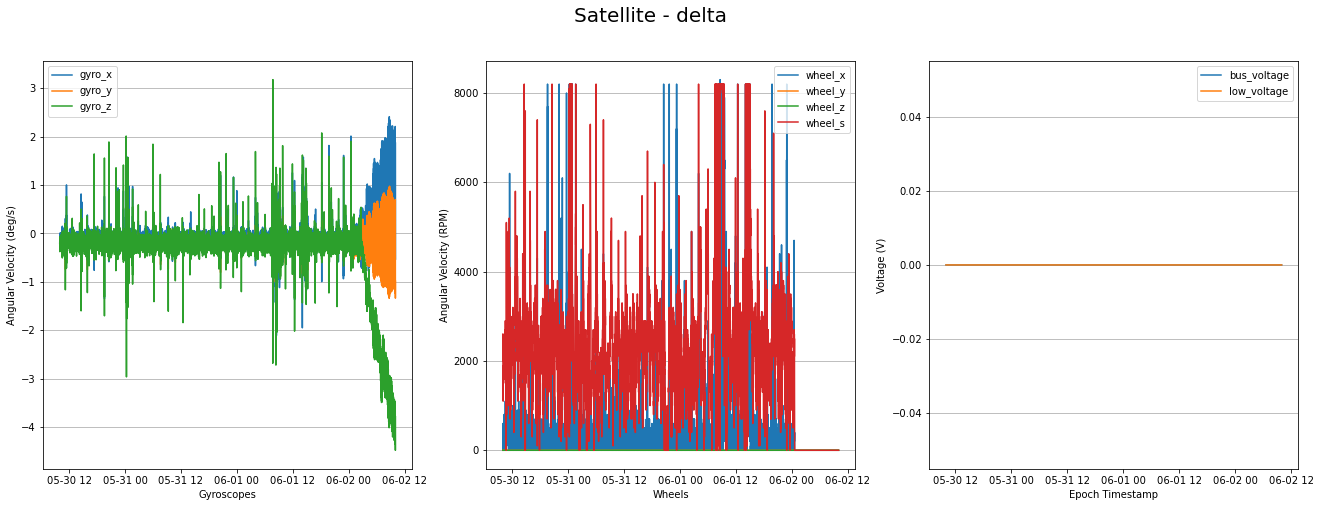

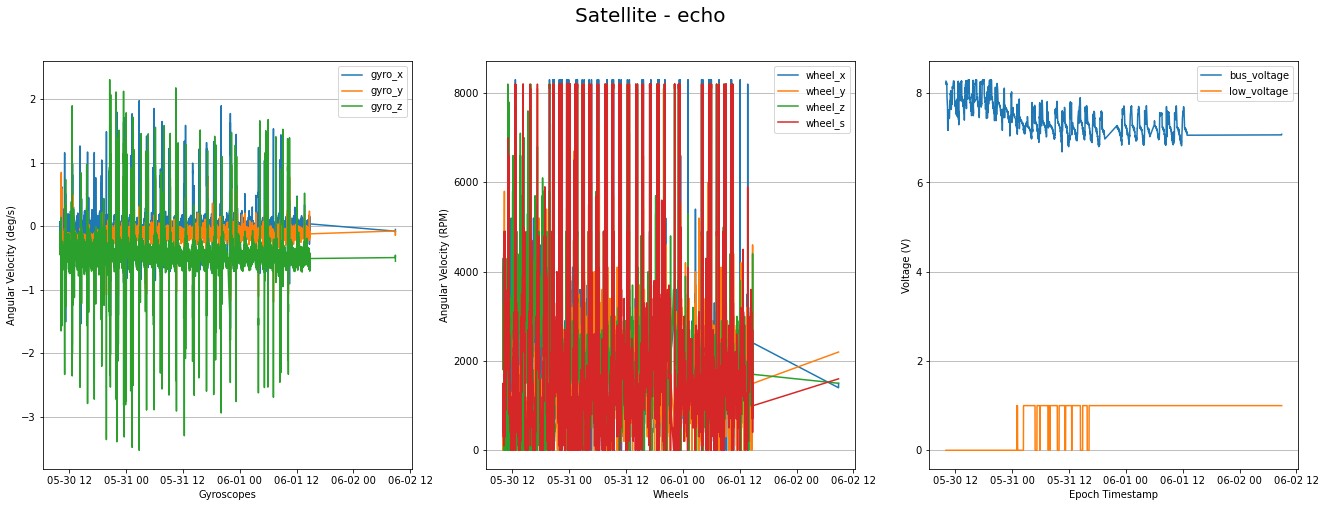

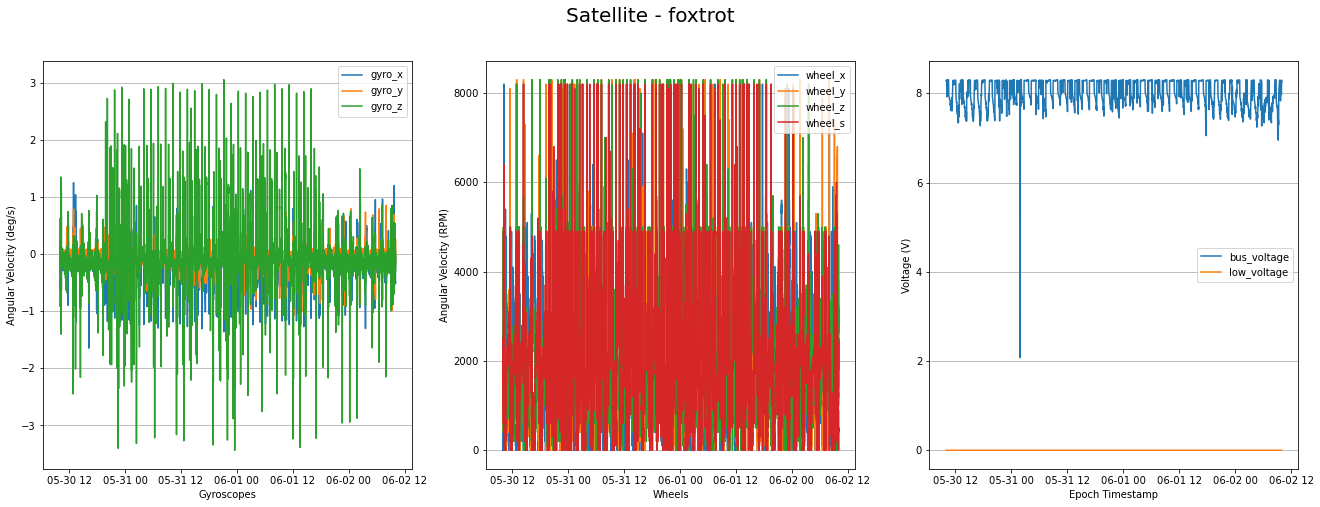

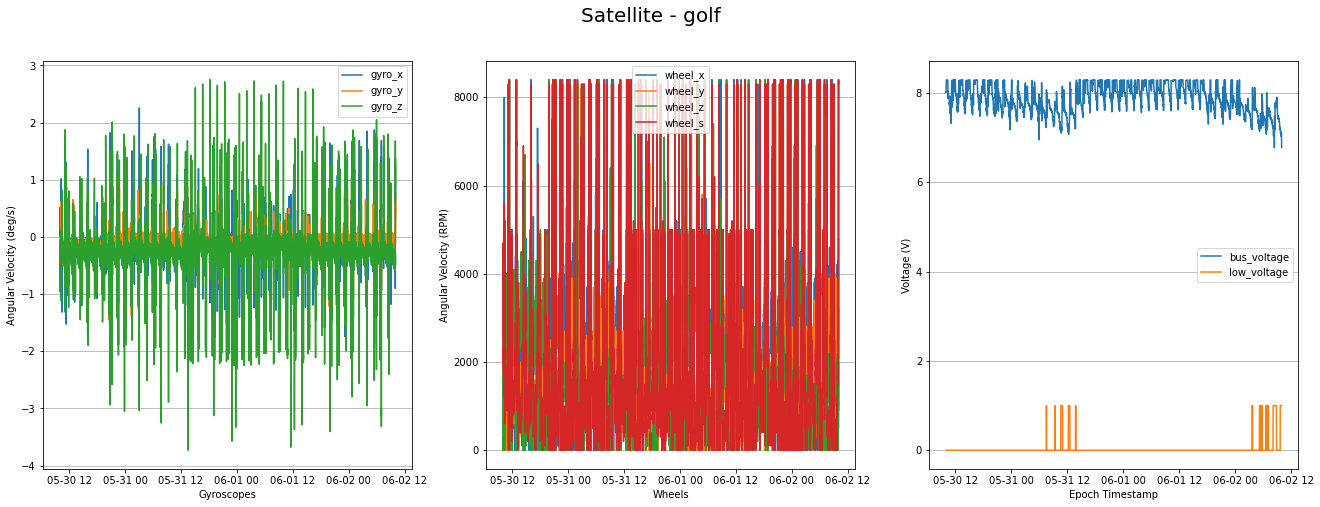

In [9]:
then = datetime.now()
# This creates time graphs for each of the seven satellites
folder = 'Timeplots _Gyros and Wheels'
for satellite in sat_id_data:
    time_filter_0 = datetime.now()
    plot1, plot1_axis = ['gyro_x', 'gyro_y', 'gyro_z'], ('Gyroscopes', 'Angular Velocity (deg/s)')
    plot2, plot2_axis = ['wheel_x', 'wheel_y', 'wheel_z', 'wheel_s'], ('Wheels', 'Angular Velocity (RPM)')
    plot3, plot3_axis = ['bus_voltage', 'low_voltage'], ('Epoch Timestamp', 'Voltage (V)')
    curr_sat_data = data.iloc[sat_id_data[satellite][0]:sat_id_data[satellite][1], :]
    gyro_data = curr_sat_data[curr_sat_data.gyro_x.notna()]
#     gyro_data = gyro_data[gyro_data.wheel_x.notna()]##
    wheel_data = curr_sat_data[curr_sat_data.wheel_x.notna()]
    voltage_data = curr_sat_data[curr_sat_data.bus_voltage.notna()]
    voltage_data = voltage_data[voltage_data.low_voltage.notna()]
    
    time_filter_1 = datetime.now() - time_filter_0
    print(f'Time to Filter Data for {satellite} is {time_filter_1}')
    
    #Create line graph using the helper function above
    xy_plots([gyro_data, wheel_data, voltage_data], columns=[plot1, plot2, plot3], plots_per_row=3,
             axes_labels=[plot1_axis, plot2_axis, plot3_axis],
             filename=f'./Q1a/{folder}/{satellite}', title=f'Satellite - {satellite}', plot_type='line')
    
    time_filter_2 = (datetime.now() - time_filter_0) - time_filter_1
    print(f'Time to Create Graphs for {satellite} is {time_filter_2}\n')

Time to Filter Data for alpha is 0:00:00.233492
Time to Create Graphs for alpha is 0:00:00.175724

Time to Filter Data for bravo is 0:00:00.134380
Time to Create Graphs for bravo is 0:00:00.133981

Time to Filter Data for charlie is 0:00:00.194140
Time to Create Graphs for charlie is 0:00:00.190490

Time to Filter Data for delta is 0:00:00.190488
Time to Create Graphs for delta is 0:00:00.138962

Time to Filter Data for echo is 0:00:00.068888
Time to Create Graphs for echo is 0:00:00.092755

Time to Filter Data for foxtrot is 0:00:00.194456
Time to Create Graphs for foxtrot is 0:00:00.473760

Time to Filter Data for golf is 0:00:00.385512
Time to Create Graphs for golf is 0:00:00.255330



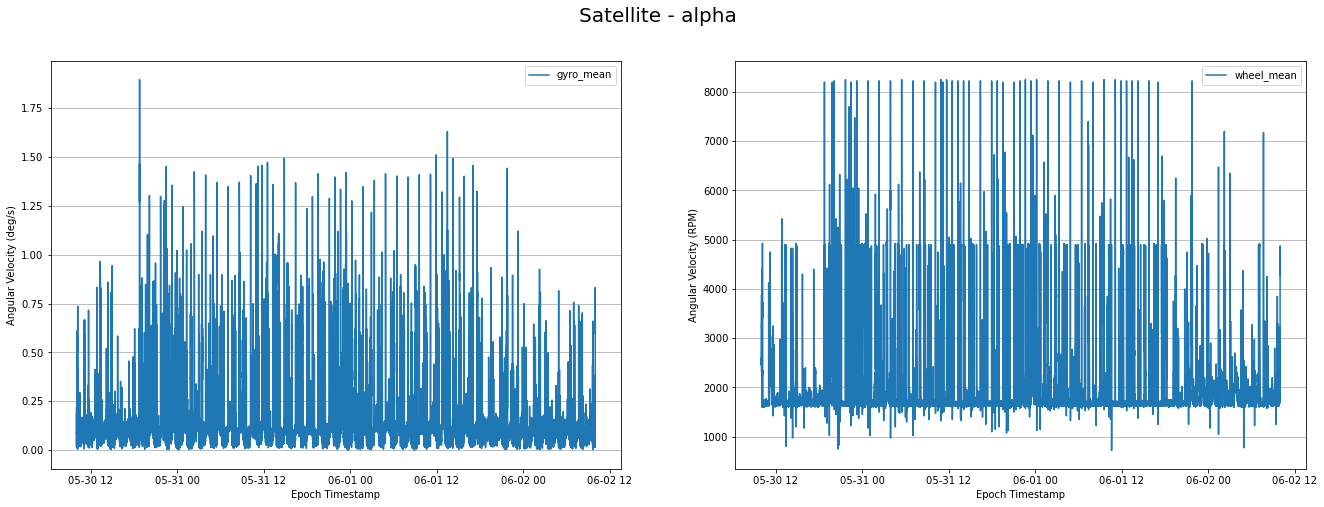

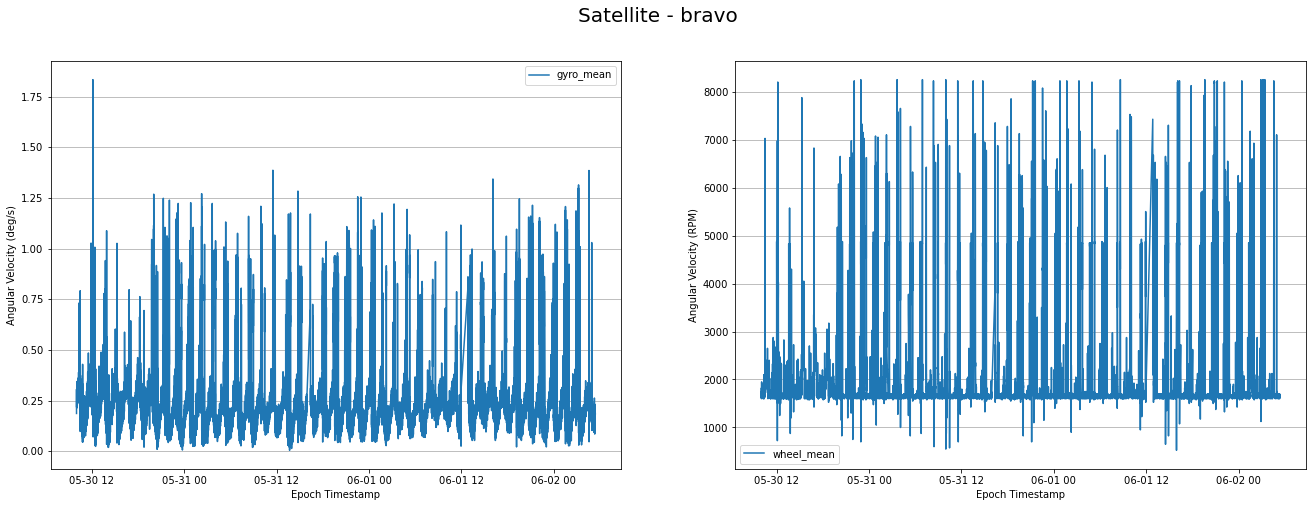

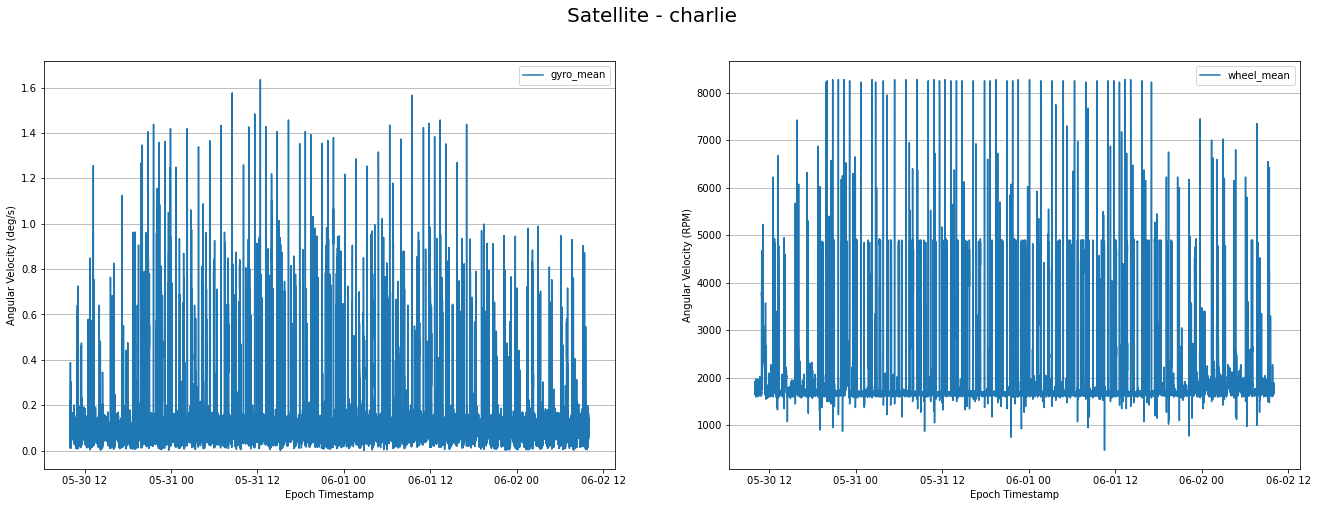

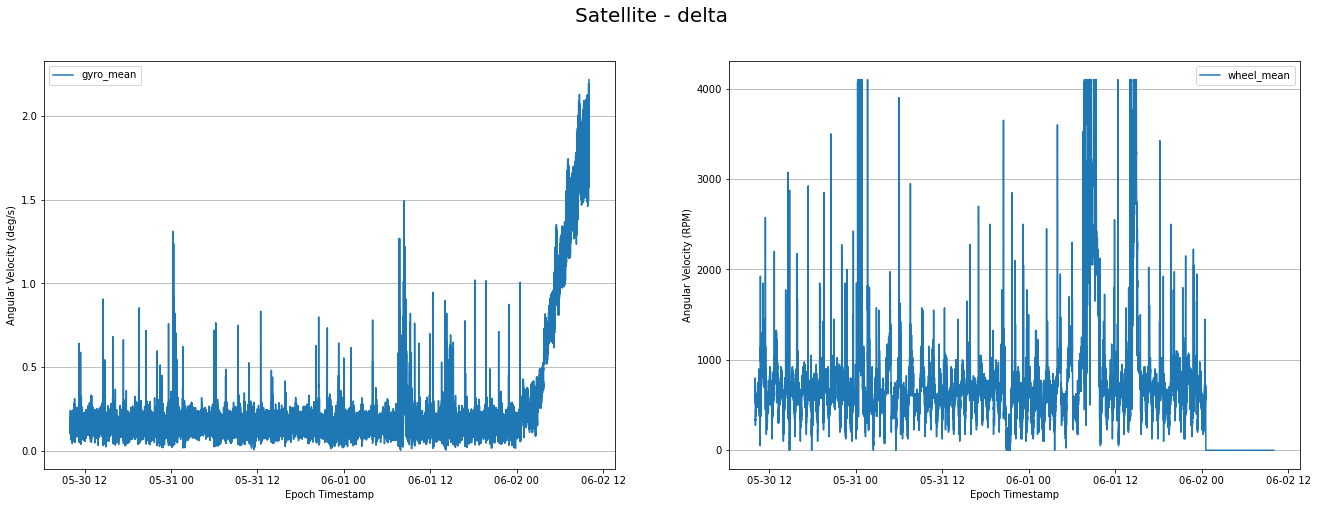

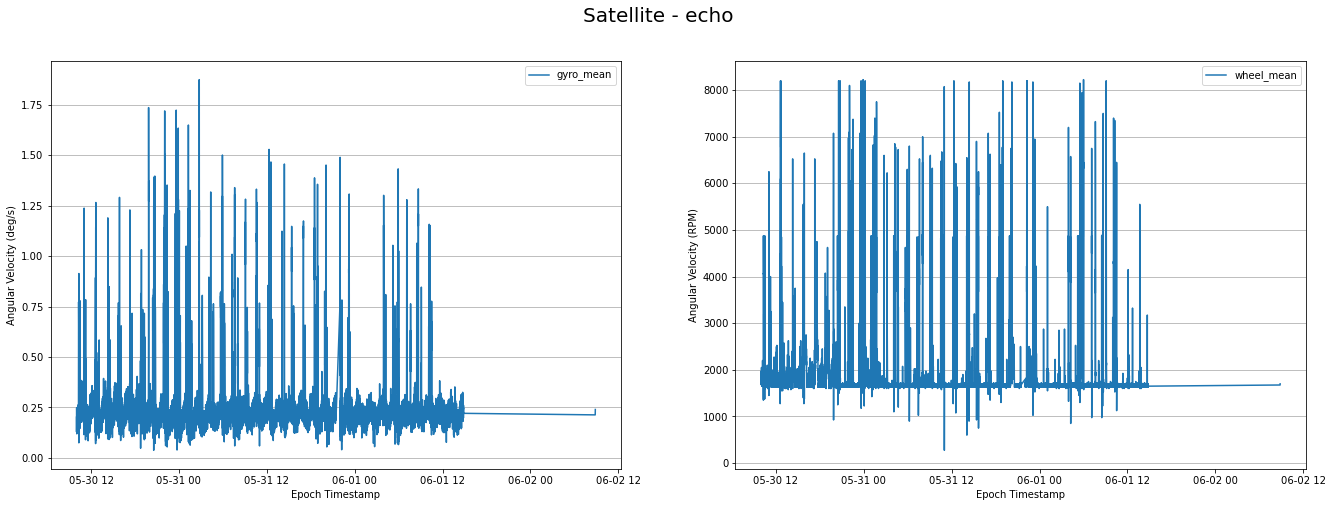

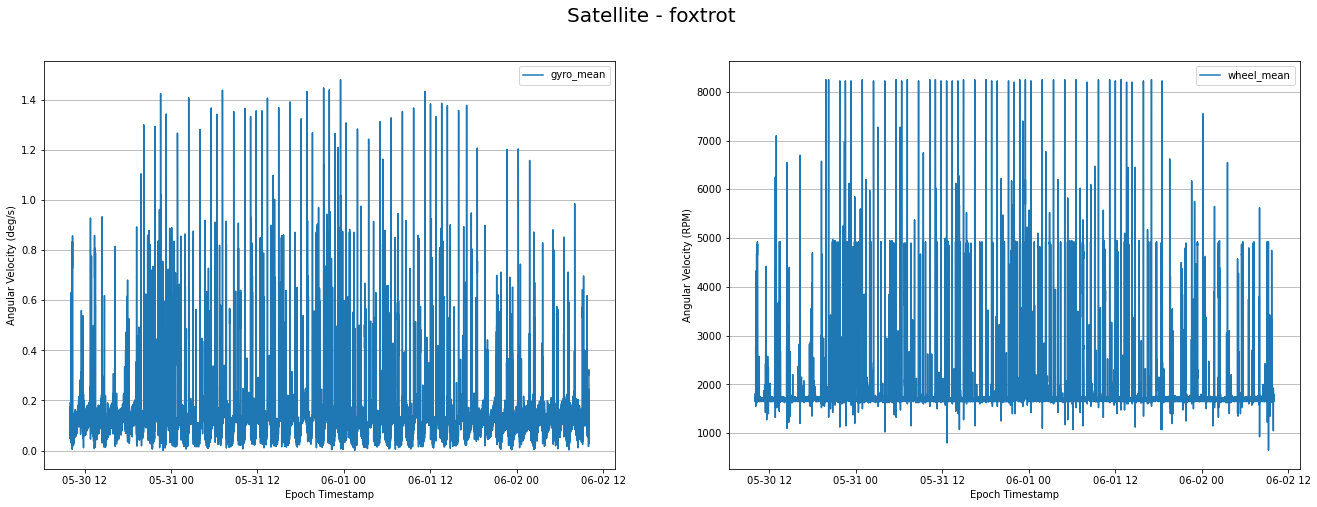

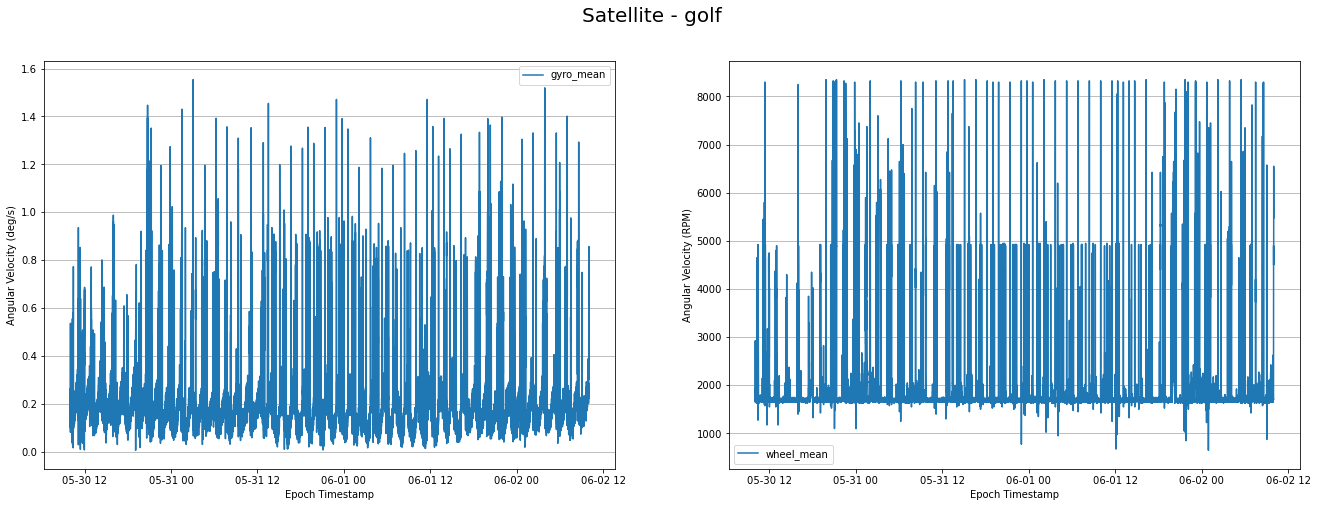

In [10]:
# This creates time graphs for gyros and wheels, averaged across x,y,and z, for each of the seven satellites
folder = 'Timeplots_Gyros and Wheels Average'
for satellite in sat_id_data:
    time_filter_0 = datetime.now()
    plot1, plot1_axis = ['gyro_mean'], ('Epoch Timestamp', 'Angular Velocity (deg/s)')
    plot2, plot2_axis = ['wheel_mean'], ('Epoch Timestamp', 'Angular Velocity (RPM)')
    curr_sat_data = data.iloc[sat_id_data[satellite][0]:sat_id_data[satellite][1], :]
    gyro_data = curr_sat_data[curr_sat_data.gyro_mean.notna()]
#     gyro_data = gyro_data[gyro_data.wheel_mean.notna()]##
    wheel_data = curr_sat_data[curr_sat_data.wheel_mean.notna()]
    
    time_filter_1 = datetime.now() - time_filter_0
    print(f'Time to Filter Data for {satellite} is {time_filter_1}')
    
    xy_plots([gyro_data, wheel_data], columns=[plot1, plot2], axes_labels=[plot1_axis, plot2_axis], 
             filename=f'./Q1a/{folder}/{satellite}', title=f'Satellite - {satellite}')
    
    time_filter_2 = (datetime.now() - time_filter_0) - time_filter_1
    print(f'Time to Create Graphs for {satellite} is {time_filter_2}\n')

#### 1b: All the telemetry channels of all the satellites combined in a single page


Time to Filter Data is 0:00:01.463922
Time to Create Graphs is 0:02:14.084911



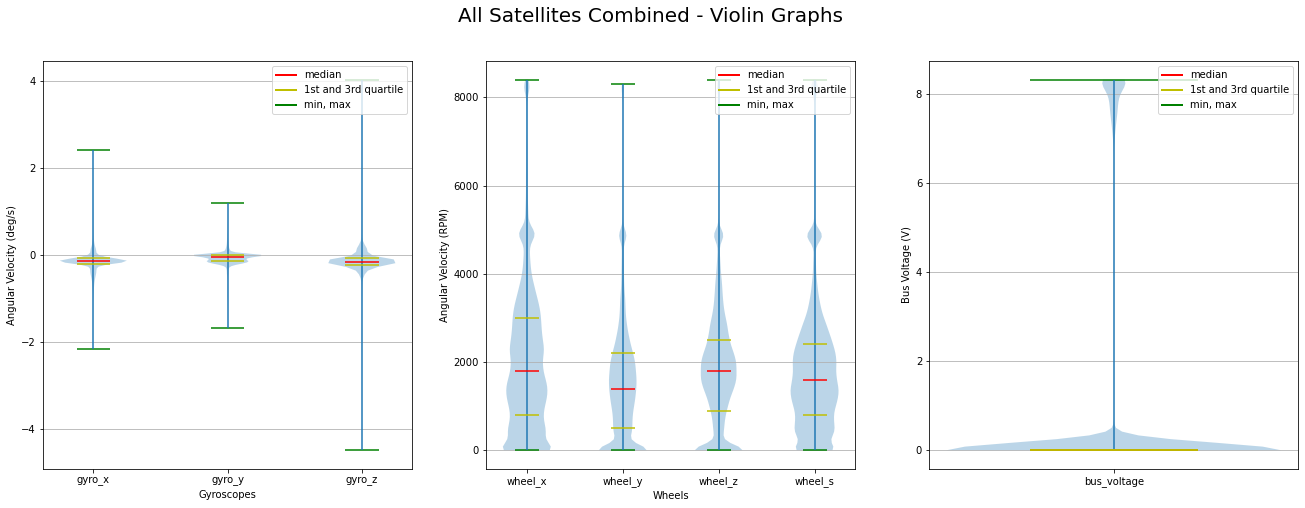

In [11]:
# This creates violin graphs for all of the seven satellites combined
file = 'Violin Plots'
time_filter_0 = datetime.now()
plot1, plot1_axis = ['gyro_x', 'gyro_y', 'gyro_z'], ('Gyroscopes', 'Angular Velocity (deg/s)')
plot2, plot2_axis = ['wheel_x', 'wheel_y', 'wheel_z', 'wheel_s'], ('Wheels', 'Angular Velocity (RPM)')
plot3, plot3_axis = ['bus_voltage'], ('', 'Bus Voltage (V)')
curr_sat_data = data
gyro_data = curr_sat_data[curr_sat_data.gyro_x.notna()]
# gyro_data = gyro_data[gyro_data.wheel_s.notna()]##
wheel_data = curr_sat_data[curr_sat_data.wheel_s.notna()]
voltage_data = curr_sat_data[curr_sat_data.bus_voltage.notna()]

time_filter_1 = datetime.now() - time_filter_0
print(f'Time to Filter Data is {time_filter_1}')

violin_graph([gyro_data, wheel_data, voltage_data], column_groups=[plot1, plot2, plot3], plots_per_row=3,
             axes_labels=[plot1_axis, plot2_axis, plot3_axis],
             filename=f'./Q1b/{file}', title='All Satellites Combined - Violin Graphs')

time_filter_2 = (datetime.now() - time_filter_0) - time_filter_1
print(f'Time to Create Graphs is {time_filter_2}\n')

Time to Filter Data is 0:00:00.759825
Time to Create Graphs is 0:00:02.597712



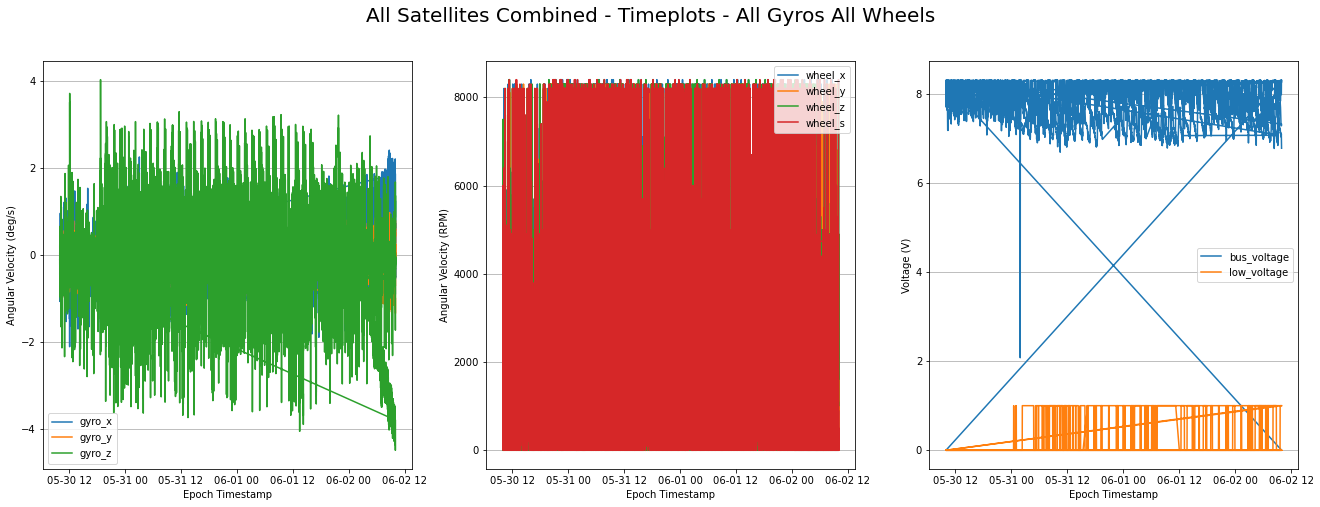

In [12]:
# This creates time graphs for all of the seven satellites combined
file = 'Scatter Timeplots - Gyros and Wheels'
time_filter_0 = datetime.now()
plot1, plot1_axis = ['gyro_x', 'gyro_y', 'gyro_z'], ('Epoch Timestamp', 'Angular Velocity (deg/s)')
plot2, plot2_axis = ['wheel_x', 'wheel_y', 'wheel_z', 'wheel_s'], ('Epoch Timestamp', 'Angular Velocity (RPM)')
plot3, plot3_axis = ['bus_voltage', 'low_voltage'], ('Epoch Timestamp', 'Voltage (V)')
curr_sat_data = data
gyro_data = curr_sat_data[curr_sat_data.gyro_x.notna()]
# gyro_data = gyro_data[gyro_data.wheel_x.notna()]##
wheel_data = curr_sat_data[curr_sat_data.wheel_x.notna()]
voltage_data = curr_sat_data[curr_sat_data.bus_voltage.notna()]
voltage_data = voltage_data[voltage_data.low_voltage.notna()]

time_filter_1 = datetime.now() - time_filter_0
print(f'Time to Filter Data is {time_filter_1}')

xy_plots([gyro_data, wheel_data,voltage_data], columns=[plot1, plot2, plot3], plots_per_row=3,
         axes_labels=[plot1_axis, plot2_axis, plot3_axis], 
         filename=f'./Q1b/{file}', title='All Satellites Combined - Timeplots - All Gyros All Wheels',
         plot_type='line')

time_filter_2 = (datetime.now() - time_filter_0) - time_filter_1
print(f'Time to Create Graphs is {time_filter_2}\n')

Time to Filter Data is 0:00:00.518439
Time to Create Graphs is 0:00:00.771388



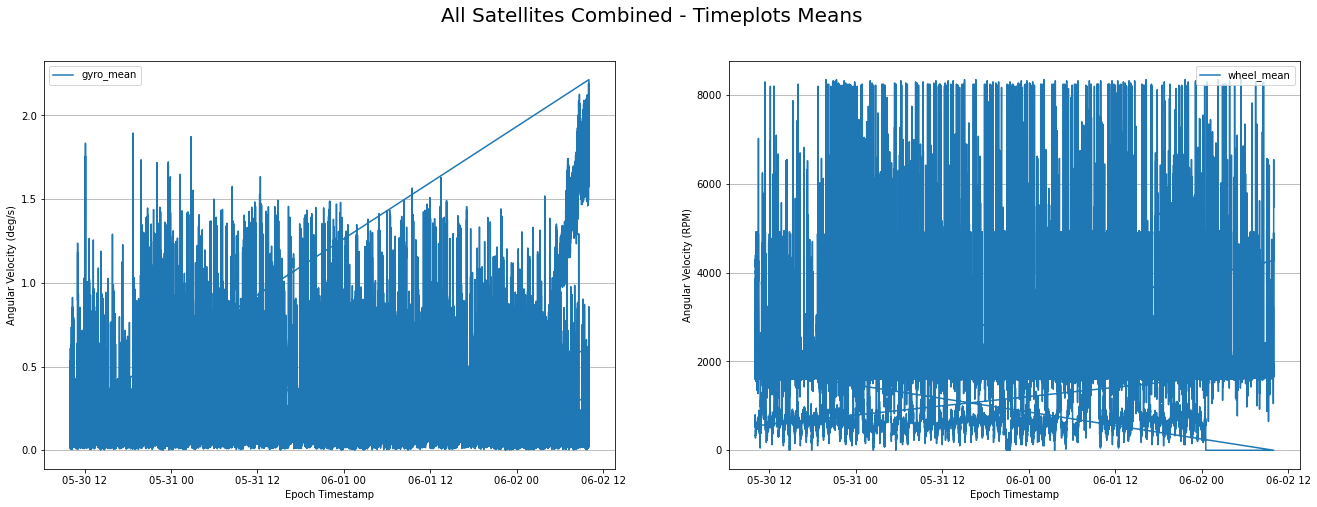

In [13]:
# This creates time graphs for gyros and wheels, averaged across x,y,and z, for all of the seven satellites combined
file = 'Timeplots_Mean Gyros and Wheels'
time_filter_0 = datetime.now()
plot1, plot1_axis = ['gyro_mean'], ('Epoch Timestamp', 'Angular Velocity (deg/s)')
plot2, plot2_axis = ['wheel_mean'], ('Epoch Timestamp', 'Angular Velocity (RPM)')
curr_sat_data = data
gyro_data = curr_sat_data[curr_sat_data.gyro_mean.notna()]
# gyro_data = gyro_data[gyro_data.wheel_mean.notna()]##
wheel_data = curr_sat_data[curr_sat_data.wheel_mean.notna()]

time_filter_1 = datetime.now() - time_filter_0
print(f'Time to Filter Data is {time_filter_1}')

xy_plots([gyro_data, wheel_data], columns=[plot1, plot2], axes_labels=[plot1_axis, plot2_axis], 
         filename=f'./Q1b/{file}', title='All Satellites Combined - Timeplots Means',
         plot_type='line')

time_filter_2 = (datetime.now() - time_filter_0) - time_filter_1
print(f'Time to Create Graphs is {time_filter_2}\n')

#### 1c: The beta angle of all the satellites, combined in a single graph

In [14]:
# Get directory containing data for beta angle
combined_sat_data_directory = os.getcwd()
combined_sat_data_directory = os.path.join(combined_sat_data_directory, 'Combined Satellite Data\\beta_sun_deg.csv')

In [15]:
#Create dataframe for beta angles
then = datetime.now()
beta_data = pd.read_csv(combined_sat_data_directory, parse_dates=[0])
beta_data.rename(columns={'Unnamed: 0': 'timestamp'}, inplace=True)
datetime.now()-then

datetime.timedelta(microseconds=46881)

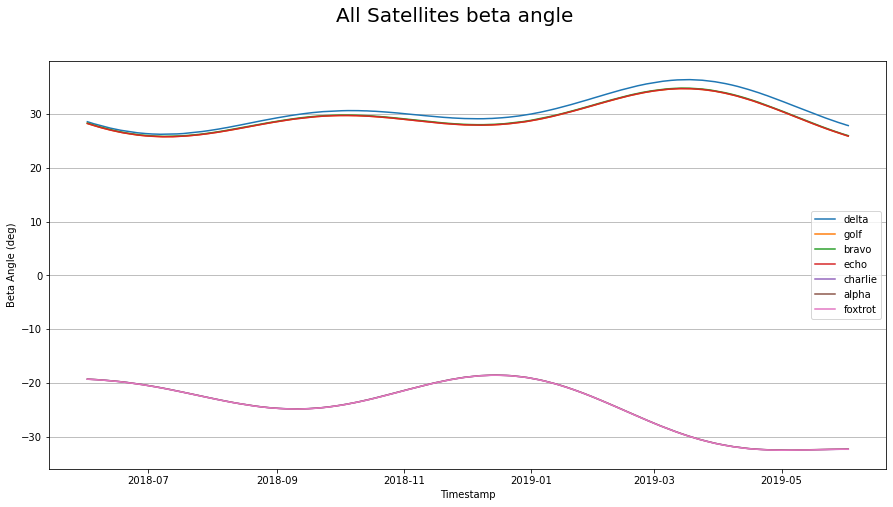

In [16]:
plot, plot_axis = ['delta', 'golf', 'bravo', 'echo', 'charlie', 'alpha', 'foxtrot'], ('Timestamp', 'Beta Angle (deg)')
xy_plots([beta_data], columns=[plot], 
         axes_labels=[plot_axis], filename='All Satellites beta angle timeplot', 
         title='All Satellites beta angle')

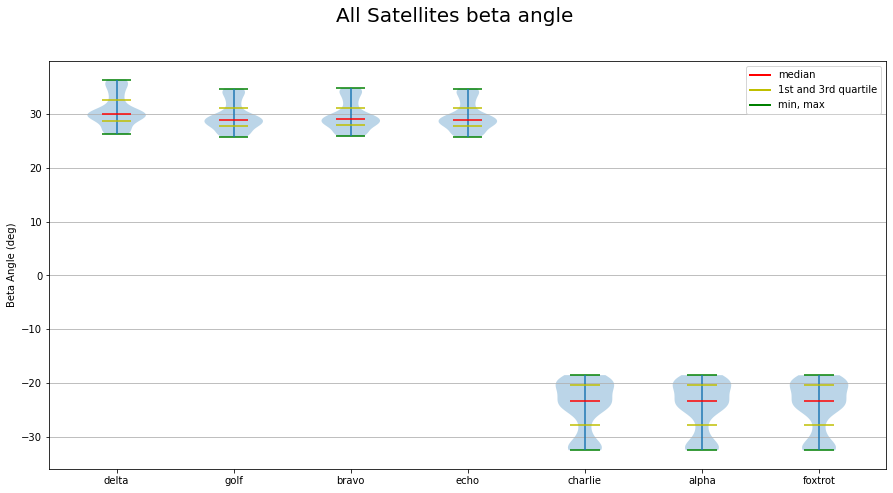

In [17]:
plot, plot_axis = ['delta', 'golf', 'bravo', 'echo', 'charlie', 'alpha', 'foxtrot'], ('', 'Beta Angle (deg)')
violin_graph([beta_data], column_groups=[plot], 
             axes_labels=[plot_axis], filename='All Satellites beta angle', 
             title='All Satellites beta angle')

#### 1d: Add any other plots that you find helpful when exploring the data set

Correlation between all variables with each other in the dataframe. This is to explore any potential correlations among the various telemetry input channels. It appears that there might be some correlation between bus voltage and wheel speed.

In [18]:
correlated_data = data.corr() #find pearson correlation
correlated_data[correlated_data > 0.5] #Filter by correlations that are atleast somewhat significant

,gyro_x,gyro_y,gyro_z,wheel_s,wheel_x,wheel_y,wheel_z,low_voltage,bus_voltage,gyro_mean,wheel_mean
gyro_x,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gyro_y,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gyro_z,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wheel_s,NaN,NaN,NaN,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,0.604930
wheel_x,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.567388,NaN,0.670797
wheel_y,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.675578,NaN,0.719641
wheel_z,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,0.745174,NaN,0.669125
low_voltage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
bus_voltage,NaN,NaN,NaN,NaN,0.567388,0.675578,0.745174,NaN,1.000000,NaN,0.711007
gyro_mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


This creates wheel mean vs. bus voltage for each of the 7 satellites. This is to visualize the mathematical correlation between wheel speed and bus voltage. The correlation can be somewhat visualized but generally hard due to so many data points.

Creating graphs for alpha
Creating graphs for bravo
Creating graphs for charlie
Creating graphs for delta
Creating graphs for echo
Creating graphs for foxtrot
Creating graphs for golf


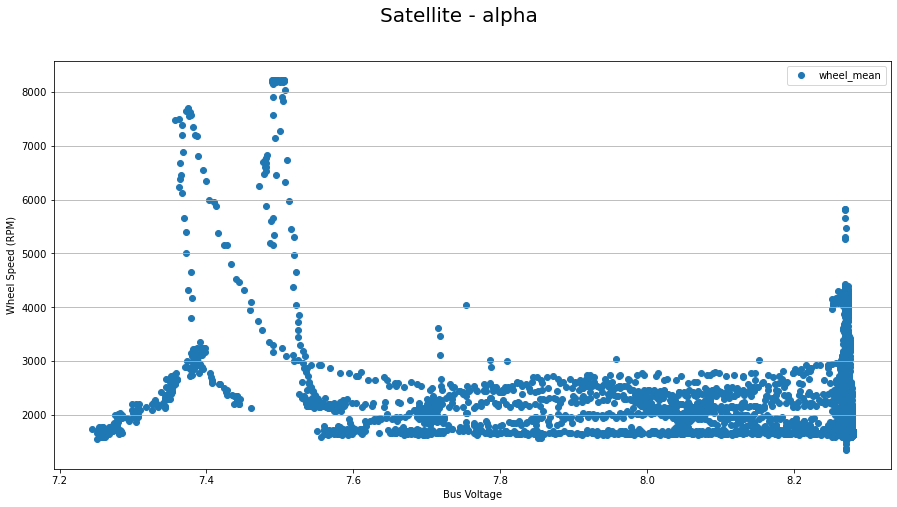

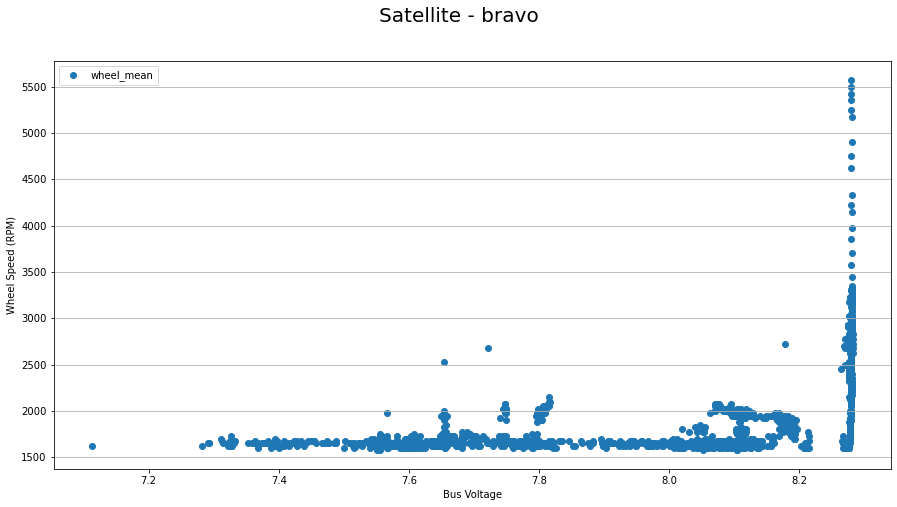

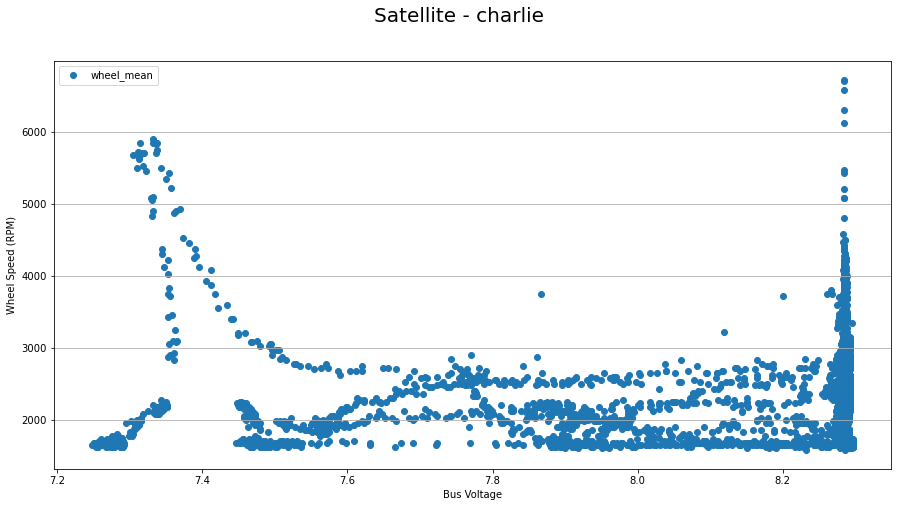

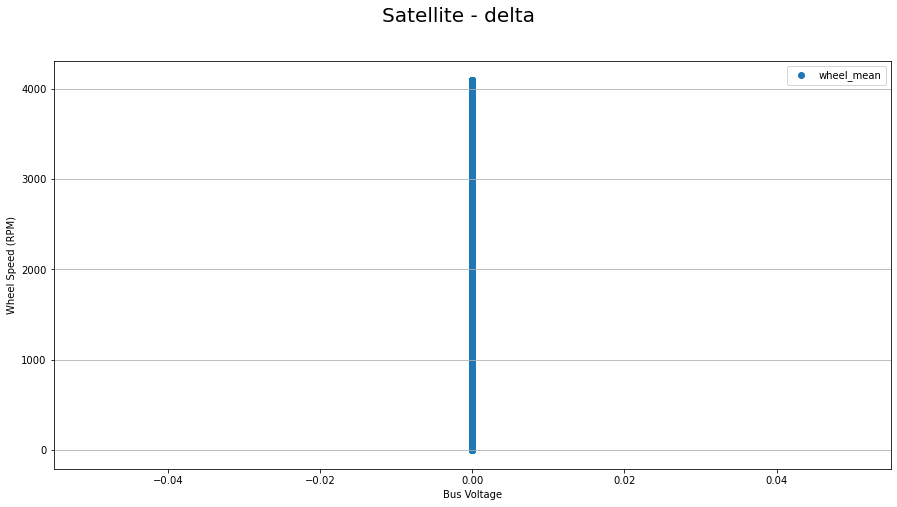

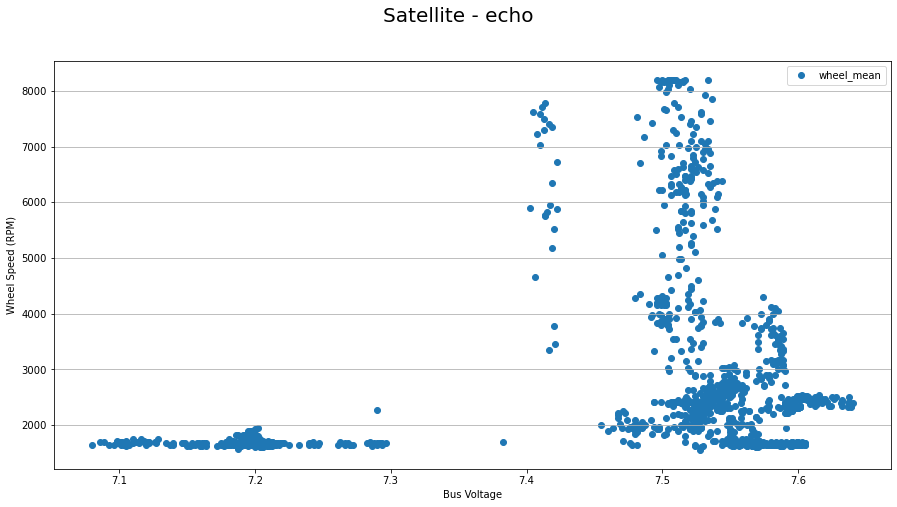

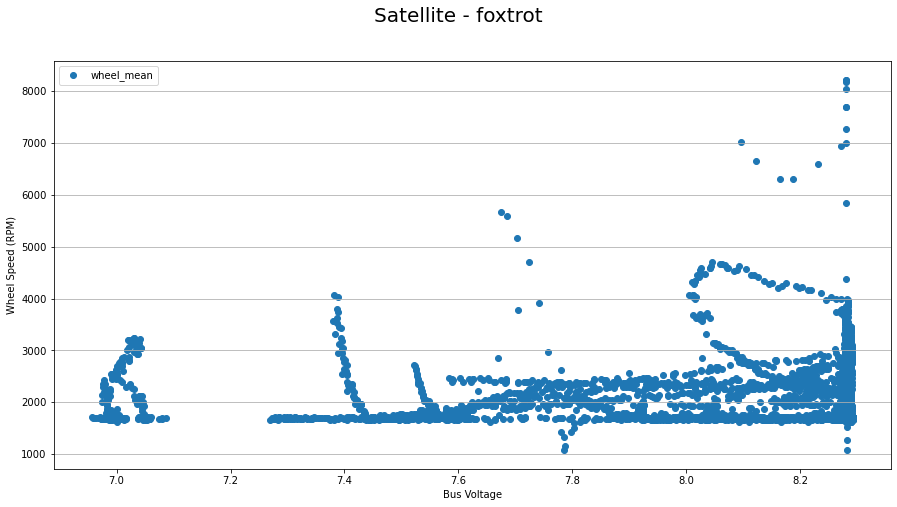

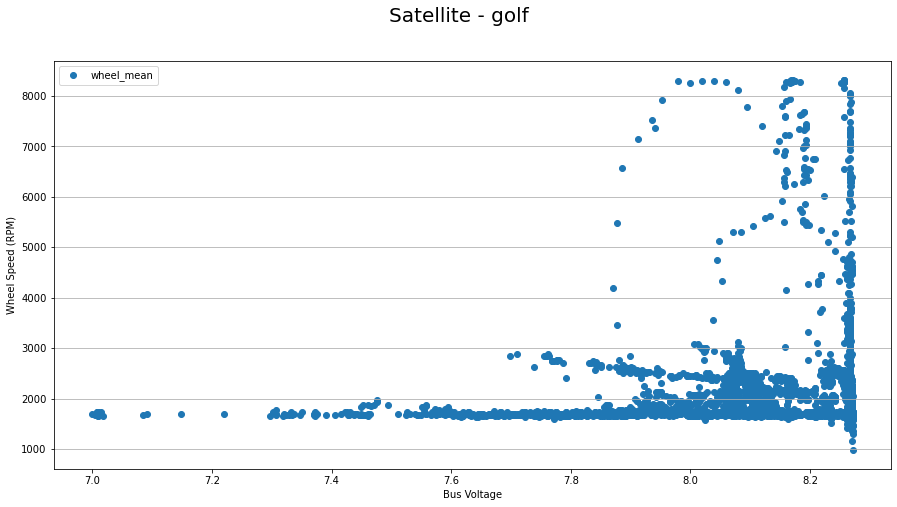

In [19]:
folder = 'Mean Wheel vs Bus Voltage'
for satellite in sat_id_data:
    print(f'Creating graphs for {satellite}')
    plot1, plot1_axis = ['wheel_mean'], ('Bus Voltage', 'Wheel Speed (RPM)')
    curr_sat_data = data.iloc[sat_id_data[satellite][0]:sat_id_data[satellite][1], :]
    corr_data = curr_sat_data[curr_sat_data['wheel_mean'].notna()]
    corr_data = corr_data[corr_data['bus_voltage'].notna()]
    xy_plots(data_array=[corr_data], columns=[plot1], 
             axes_labels=[plot1_axis], 
             filename=f'./Q1a/{folder}/{satellite}', title=f'Satellite - {satellite}', x_axis='bus_voltage',
             plot_type='scatter')

This creates Low Voltage vs. Wheel Speed for each of the 4 wheels for each of the 7 satellites on four different plots. Bus voltage vs. wheel speed correlation was hard to visualize in the graph. A trend with low wheel speeds at low voltage can be seen for bravo and I would have liked to see that for echo as well, but since there are no instances where low voltage signal and low wheels speeds are available within the same epoch, it cannot be determined.

Creating graphs for alpha
Creating graphs for bravo
Creating graphs for charlie
Creating graphs for delta
Creating graphs for echo
Creating graphs for foxtrot
Creating graphs for golf


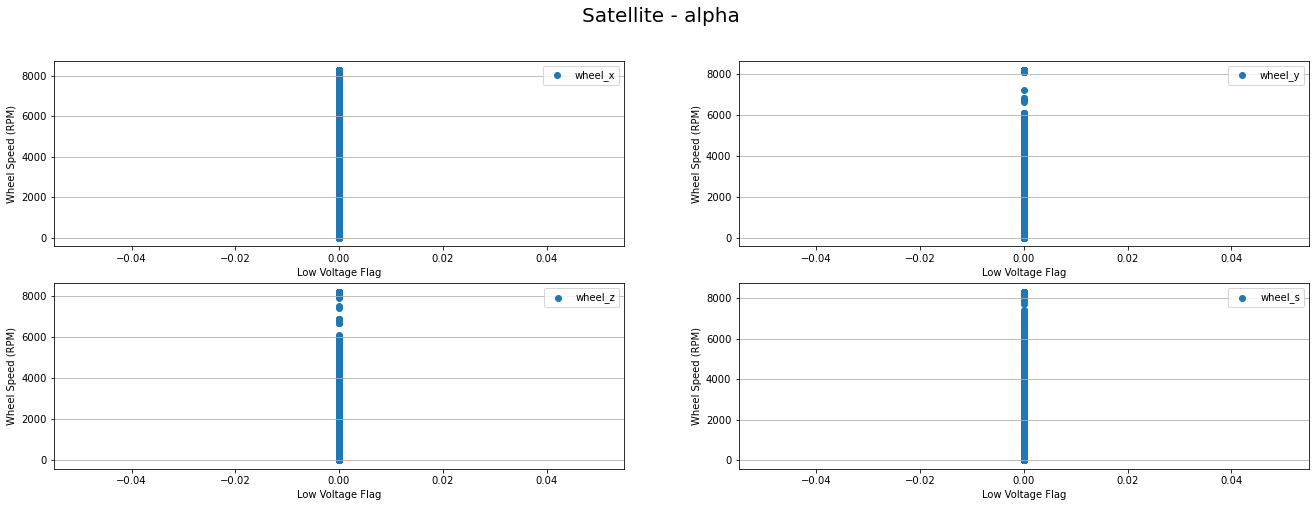

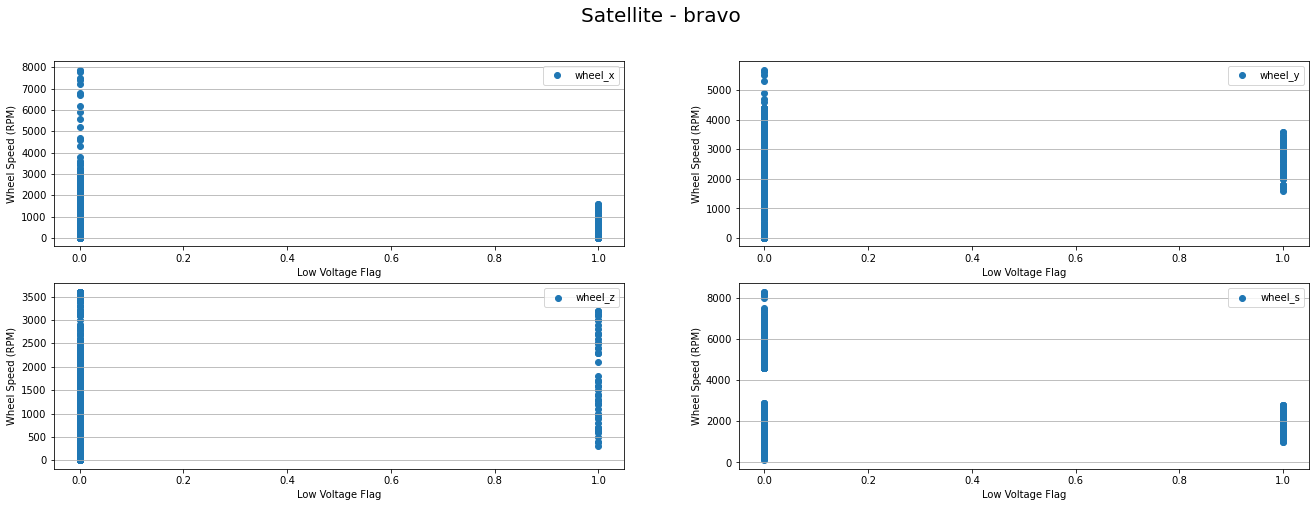

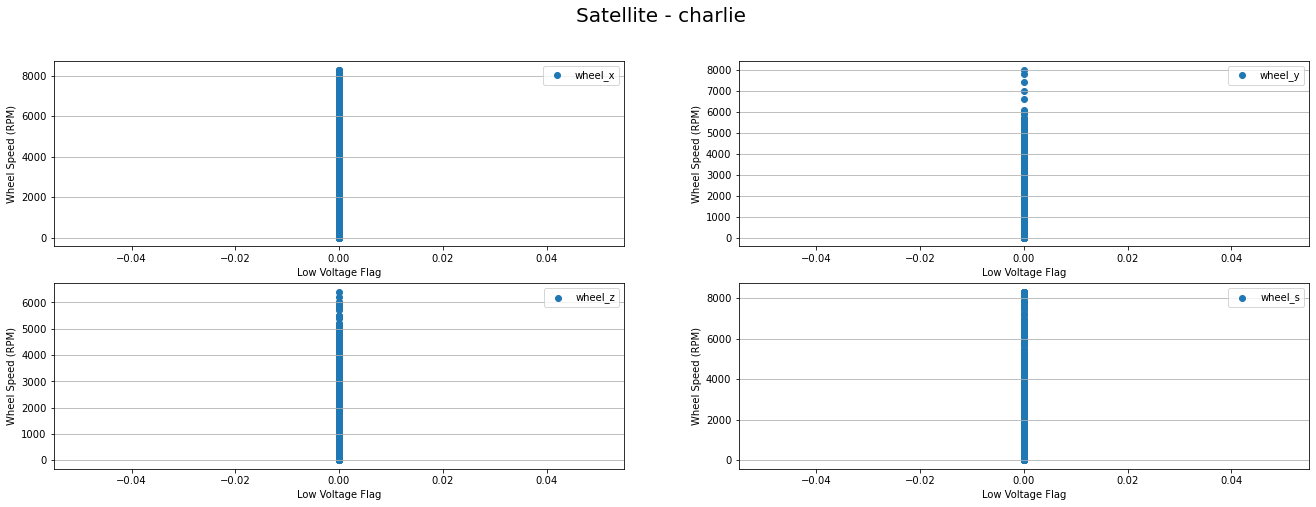

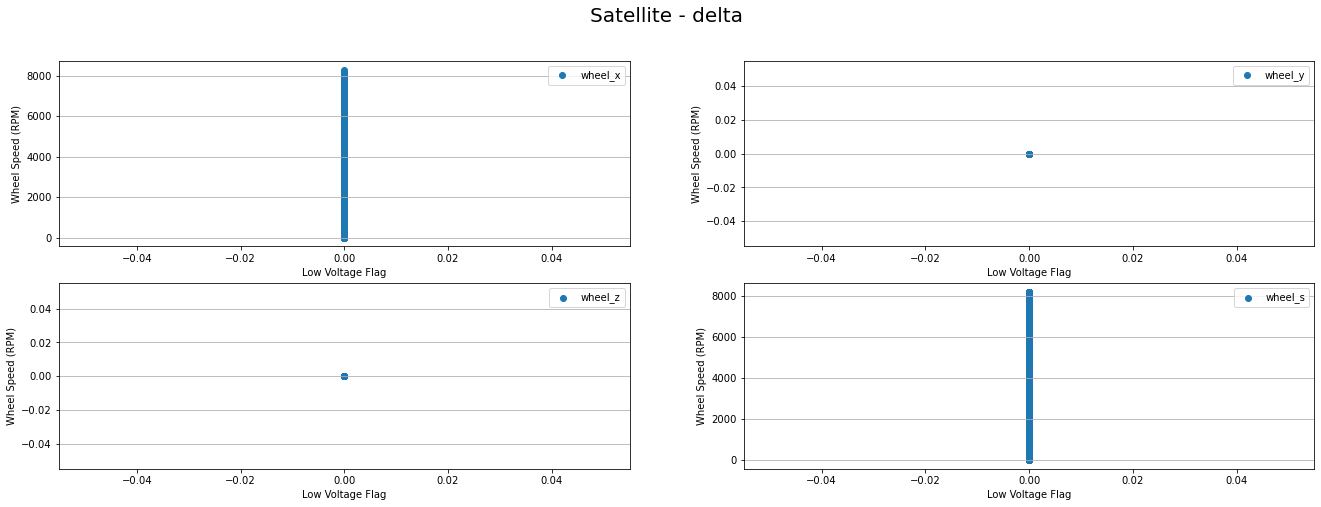

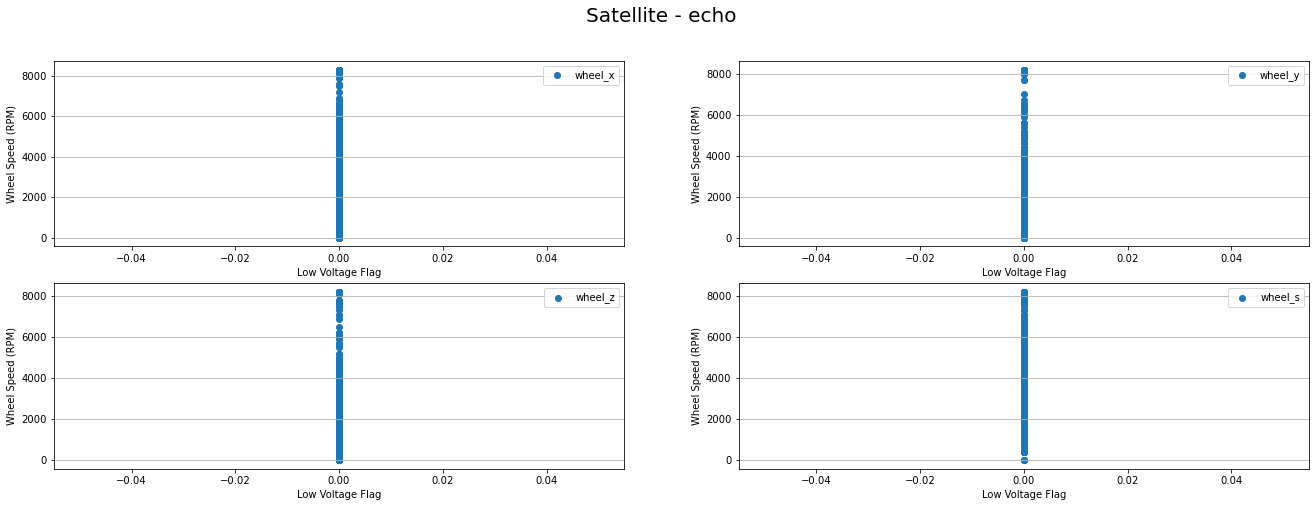

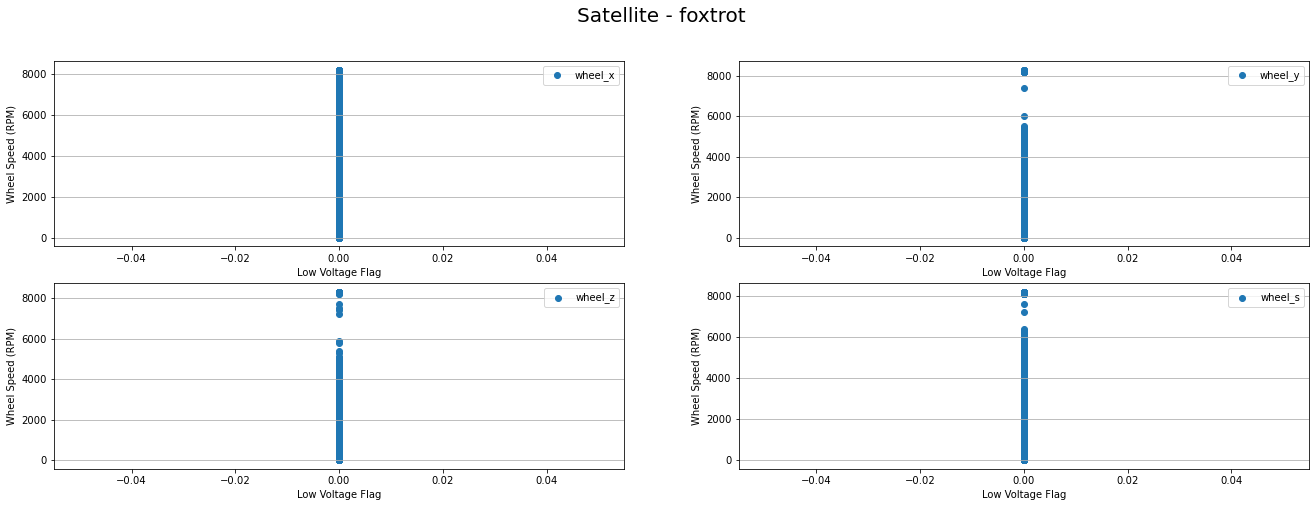

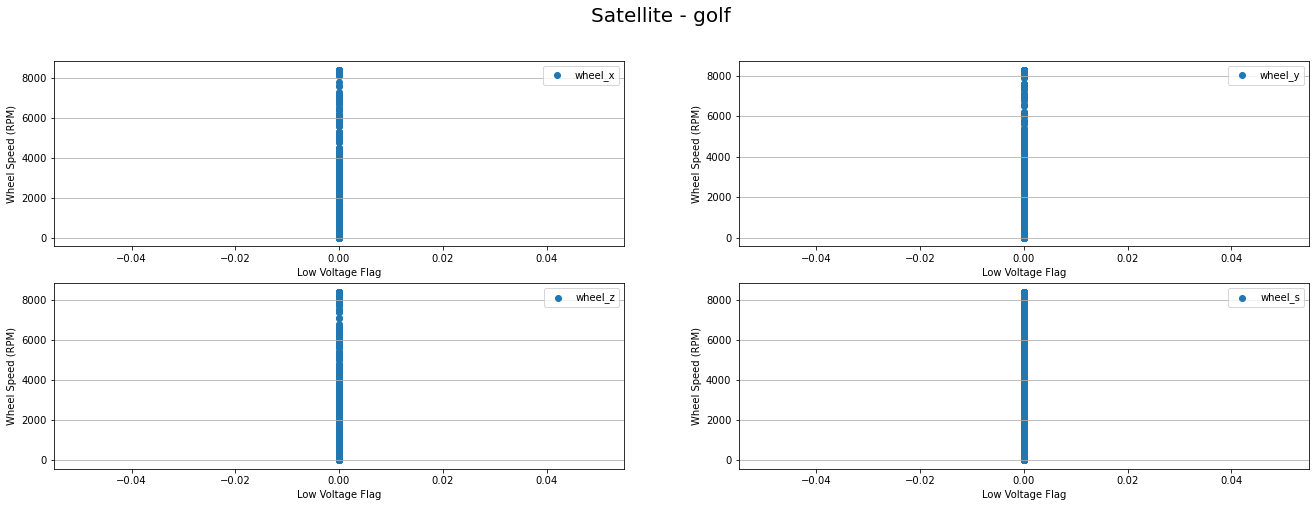

In [20]:
folder = 'Wheel Speed vs. low voltage'
for satellite in sat_id_data:
    print(f'Creating graphs for {satellite}')
    plot1, plot1_axis = ['wheel_x'], ('Low Voltage Flag', 'Wheel Speed (RPM)')
    plot2, plot2_axis = ['wheel_y'], ('Low Voltage Flag', 'Wheel Speed (RPM)')
    plot3, plot3_axis = ['wheel_z'], ('Low Voltage Flag', 'Wheel Speed (RPM)')
    plot4, plot4_axis = ['wheel_s'], ('Low Voltage Flag', 'Wheel Speed (RPM)')
    curr_sat_data = data.iloc[sat_id_data[satellite][0]:sat_id_data[satellite][1], :]
    wheel_voltage_data = curr_sat_data[curr_sat_data.low_voltage.notna()]
    wheel_voltage_data = wheel_voltage_data[wheel_voltage_data.wheel_s.notna()]
    xy_plots(data_array=[wheel_voltage_data, wheel_voltage_data, wheel_voltage_data, wheel_voltage_data], 
             columns=[plot1, plot2, plot3, plot4], 
             axes_labels=[plot1_axis, plot2_axis, plot3_axis, plot4_axis], 
             filename=f'./Q1a/{folder}/{satellite}', title=f'Satellite - {satellite}', x_axis='low_voltage',
             plot_type='scatter')

#### Q2: For each satellite, compute the percentage of the available telemetry points where:

#### 2a: The wheels get saturated at their maximum speeds (average for all of the active wheels)

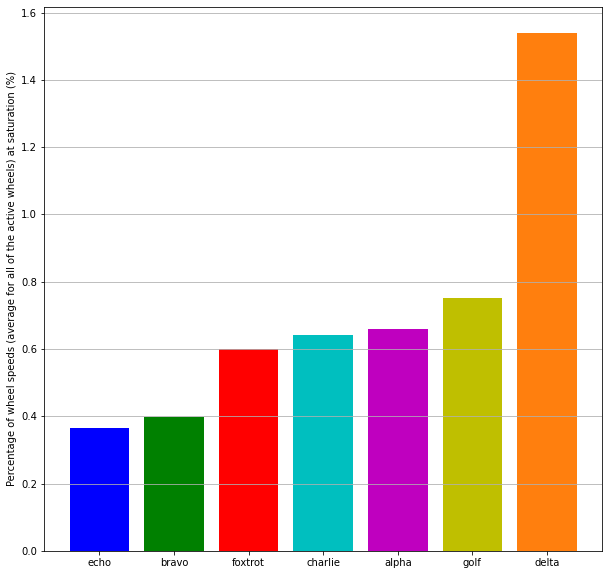

In [21]:
# Calculates percentage of saturated wheels using all active wheels only (wheel speeds > 0).
wheels_mean = average_across_columns(data, column_groups=[['wheel_s', 'wheel_x', 'wheel_y', 'wheel_z']],
                                               new_column_names=['wheel_mean'], method=['active_only'])
percentage_array = []
for satellite in sat_id_data:
    wheels_mean_available = wheels_mean.iloc[sat_id_data[satellite][0]:sat_id_data[satellite][1]]
    wheels_mean_available = wheels_mean_available.dropna()
    wheels_mean_available_saturated = wheels_mean_available[wheels_mean_available.wheel_mean >= 8000]

    percent = wheels_mean_available_saturated.shape[0]/wheels_mean_available.shape[0] * 100
    percentage_array.append(percent)

percentage_array = dict(zip(sat_id_data.keys(),percentage_array))
percentage_array = {k:v for k,v in sorted (percentage_array.items(), key=lambda x: x[1])}

fig, ax = plt.subplots(figsize=(10,10))
width = 0.2
x = [i for i in range(len(percentage_array))]
rect1 = ax.bar(x, percentage_array.values(), color=['b', 'g', 'r', 'c', 'm', 'y', 'tab:orange',])
ax.set_xticks(x)
ax.set_xticklabels(percentage_array.keys())
ax.set_ylabel('Percentage of wheel speeds (average for all of the active wheels) at saturation (%)')
ax.grid(True, axis='y')

#### 2b: The low voltage flag is active

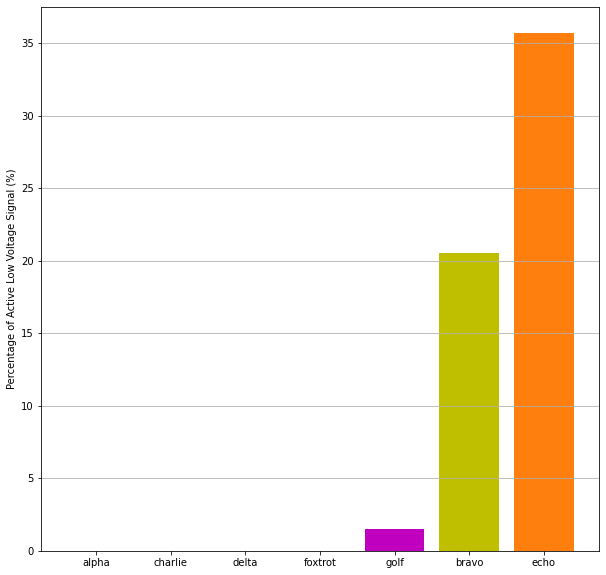

In [22]:
percentage_array = []
for satellite in sat_id_data:
    low_voltage_available = data.iloc[sat_id_data[satellite][0]:sat_id_data[satellite][1]]
    low_voltage_available = low_voltage_available[low_voltage_available.low_voltage.notna()]
    low_voltage_available_active = low_voltage_available[low_voltage_available.low_voltage == 1]
    percent = low_voltage_available_active.shape[0] / low_voltage_available.shape[0] * 100
    percentage_array.append(percent)

percentage_array = dict(zip(sat_id_data.keys(),percentage_array))
percentage_array = {k:v for k,v in sorted (percentage_array.items(), key=lambda x: x[1])}

fig, ax = plt.subplots(figsize=(10,10))
width = 0.2
x = [i for i in range(len(percentage_array))]
rect1 = ax.bar(x, percentage_array.values(), color=['b', 'g', 'r', 'c', 'm', 'y', 'tab:orange',])
ax.set_xticks(x)
ax.set_xticklabels(percentage_array.keys())
ax.set_ylabel('Percentage of Active Low Voltage Signal (%)')
ax.grid(True, axis='y')

#### 2c: The gyro rates are over two degrees per second (average for all axes)

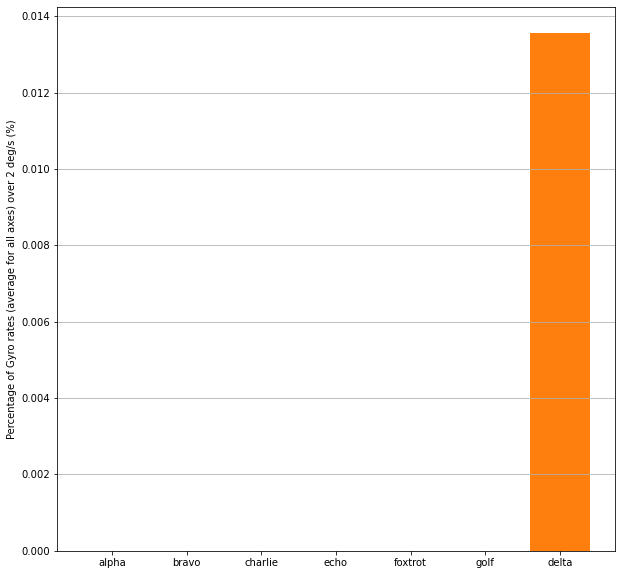

In [23]:
percentage_array = []
for satellite in sat_id_data:
    gyro_mean_available = data.iloc[sat_id_data[satellite][0]:sat_id_data[satellite][1]]
    gyro_mean_available = gyro_mean_available[gyro_mean_available.gyro_mean.notna()]
    gyro_mean_available_twodegrees = gyro_mean_available[gyro_mean_available.gyro_mean > 2]
    percent = gyro_mean_available_twodegrees.shape[0] / gyro_mean_available.shape[0] * 100
    percentage_array.append(percent)
    
percentage_array = dict(zip(sat_id_data.keys(),percentage_array))
percentage_array = {k:v for k,v in sorted (percentage_array.items(), key=lambda x: x[1])}

fig, ax = plt.subplots(figsize=(10,10))
width = 0.2
x = [i for i in range(len(percentage_array))]
rect1 = ax.bar(x, percentage_array.values(), color=['b', 'g', 'r', 'c', 'm', 'y', 'tab:orange',])
ax.set_xticks(x)
ax.set_xticklabels(percentage_array.keys())
ax.set_ylabel('Percentage of Gyro rates (average for all axes) over 2 deg/s (%)')
ax.grid(True, axis='y')

#### 2d: Average Wheel Speed

In [24]:
percentage_average_wheels_mean = []
for satellite in sat_id_data:
    wheels_mean_available = data.iloc[sat_id_data[satellite][0]:sat_id_data[satellite][1]]
    wheels_mean_available = wheels_mean_available['wheel_mean']
    wheels_mean_available = wheels_mean_available[wheels_mean_available.notna()]
    percent = wheels_mean_available.mean()
    percentage_average_wheels_mean.append((satellite, percent))

percentage_average_wheels_mean

[('alpha', 2035.9789935498866),
 ('bravo', 2032.3742983867803),
 ('charlie', 2001.4153519417475),
 ('delta', 662.9896756242221),
 ('echo', 1999.4519768420012),
 ('foxtrot', 1961.6885270616615),
 ('golf', 2042.515444448001)]

#### 3. In light of the results, answer to the following questions:

#### 3a: The SkySat constellation is divided into what we call “flocks” of satellites, which are batches of satellites launched at the same time by the same vehicle. How many flocks can you distinguish in these 7 satellites? How can you tell? Which satellites belong to each flock?

I believe there are two different flocks of satellites. I am basing my argument on the beta angle graphs for all satellites. The graphs show two groups of satellites, each group belonging to a particular beta at a given time. Bravo, Delta, Echo and Golf belong to one flock where as Alpha, Charlie and Foxtrot belong to the other flock.

#### 3b: From the plots, some satellites clearly show certain anomalies that could potentially be dangerous for their operations, can you identify at least three of them? There is no need to conjecture about the reasons for it yet, one or two sentences could be enough.

For the sake of discussions below:

Orbital Plane 1: Orbit of bravo, delta, echo and golf 

Orbital Plane 2: Orbit of alpha, charlie, and foxtrot

The anomalies identified from the data are as follows:

First, delta shows drift relative to its "flock" in its beta angle and this drift increases over the course of a year, going from 0 deg drift (relative to the flock) to about 1-2 deg drift about a year later. 

Second, two of the four wheels on delta seem to be not working at all. After June 2, it seems that all wheels stop working which causes the gyroscope reading to shoot up. 

Third, the bus voltage for delta is always 0.

Fourth, echo also seems to have issues with low voltage flags. Beyond roughly May 31, echo's bus voltage stayed low and the low voltage flag beyond this time was mostly active. After about a day later (beyond June 1 around 12pm), echo pretty much stops communicating with the ground station.

Fifth, bravo seems to be having issues in terms of keeping its bus voltage at the appropriate level. This might cause the satellite to see the same fate as echo eventually. 

Sixth, golf also seems to show issues with low bus voltages towards the end and seems to trend in a downward direction. 

Finally, the percentage of the time where wheels get saturated at their maximum speeds varies more widely among satellites in orbital plane 1 than in orbital plane 2.

<!-- Third, after June 2 (when all wheels seem to be dead), the gyroscope readings (absolute average across all axes) for delta satellite are over 2 deg; all gyroscope readings (absolute average across all axes) for all other satellites are below 2 deg. Fourth, the percentage of the time where the average of the active wheels (wheels where rpm > 0) is saturated (> 8000 rpm) is 1.5% compared to 0.75% or less for all other satellites. -->

<!-- to not be able to maintain the wheel speed required to maintain its attitude.   -->

<!-- From the correlation, the wheel speeds seem to be somewhat correlate to the bus voltage, hence a lower bus voltage might affect wheels from accelerating to the desired speed. -->

#### 4. For the anomalies identified, create a separate Python function that:

#### 4a: Takes as input a telemetry channel

In [30]:
#Class that handles an input telemetry channel to detect whether there is an issue or not. Currently this class can only handle flags associated with wheel_saturation, gyro rates over two degrees, and low voltages. It would also be worth analyzing the number of active wheels on a satellite since the failure of more than two wheels would likely be catastrophic for the satellite.
class TelemetryObject():
    def __init__(self, input_array, threshold=None, percentage_flag=None):
        
        self.telemetry_input_name = input_array.name 
        self._clean_input_array = input_array.dropna()   #drop NaN from the Series
        
        #Threshold defaults: Wheel Saturation = 8000, Gyro Rates = 2, Low Voltage = 1 based on analysis in Q2 a,b and c
        self.threshold = threshold 
        
        #Percentage Flag defaults: Wheel Saturation = 1%, Gyro Rates = 0.0001%, Low Voltage = 5% based on analysis in Q2 a,b and c
        self.percentage_flag = percentage_flag 
        
        #The output flag for an input telemetry channel will be dependent on the input channel name 
        if 'wheel' in input_array.name:
            self.result = self._wheel_speed_saturation_flag() 
        elif 'gyro' in input_array.name:
            self.result = self._gyro_over_speed()
        elif 'low_voltage' in input_array.name:
            self.result = self._low_voltage_flag()
        else: 
            raise ('Script is not able to analyze the given telemetry channel')
        
    def _percentage(self, a):
        self.percentage = a.shape[0] / self._clean_input_array.shape[0] * 100
        return self.percentage
    
    def _set_percentage_flag(self, a):
        if not self.percentage_flag:
            self.percentage_flag = a
    
    def _set_threshold(self, a):
        if not self.threshold:
            self.threshold = a
    
    def _wheel_speed_saturation_flag(self):
        
        '''
        The method _wheel_speed_saturation_flag assumes that the telemetry input will be the wheel speed averaged across x,y,z 
        and s. This is because my interpretation of the question is that the function is to be defined in relation to the 
        anomalies identified in Q2 (where the wheel saturation percentage was based on 'average for all the active wheels'). In 
        reality, this would need more thought if the input were a single wheel speed channel. The flag condition in that case 
        could be based on statisitical distribution of values as well as max allowable values.

        Also, in reality the telemetry channel input may consist of all the individual wheel speeds and the task would be to 
        perform the averaging first and then do the analysis. If that were the case, the function average_across_columns 
        (located in helper functions above) would be used to get the average.
        '''
    
        self._set_threshold(8000)
        wheel_saturated = self._clean_input_array[self._clean_input_array >= self.threshold] #drop all data point less than 8000
        percentage_val = self._percentage(wheel_saturated)
        self._set_percentage_flag(1)
        if percentage_val >= self.percentage_flag: # Default threshold of 1 from analysis of bar graphs in Q2a.
            return True

        return False
    
    def _low_voltage_flag(self):
        self.threshold = 1
        low_voltage = self._clean_input_array[self._clean_input_array >= self.threshold] #drop data points with 0 values because 0 values means normal voltage
        percentage_val = self._percentage(low_voltage)
        self._set_percentage_flag(5)
        if percentage_val > self.percentage_flag: #default threshold of 5 from analysis of bar graphs in Q2b.
            return True
        
        return False


    def _gyro_over_speed(self):
        '''
        This function assumes that the telemetry input will be the gyro rates averaged across x,y and z. This is because 
        my interpretation of the question is that the function is to be defined in relation to the anomalies identified in Q2 
        (where the gyro rates over two degrees based on average for all axes). In reality, this would need more thought if the 
        input were a single gyro channel. The flag condition in that case could be based on statisitical distribution of values 
        as well as max allowable values. 

        Also, in reality the telemetry channel input may consist of all the gyro rates and the task would be to perform the 
        averaging first and then do the analysis. If that were the case, the function average_across_columns (located in helper 
        functions above) would be used to get the average.
        '''
        self._set_threshold(2)
        gyro_over_speed = self._clean_input_array[self._clean_input_array >= self.threshold] #drop data points with values less than 2
        percentage_val = self._percentage(gyro_over_speed)
        self._set_percentage_flag(0.0001)
        if percentage_val > self.percentage_flag: #Default threshold of 0.0001 from analysis of bar graphs in Q2c.
            return True
    
        return False

#### 4b: Returns a boolean, specifying if the issue in question is present (True) or not (False). There should not be false positives.

In [26]:
#The input to the function below must be a pandas Series. In reality, it might be more convenient to have a numpy input array. Since I am using pandas throughout, I will use pandas series as my input.
def telemetry_flag_detector(telemetry_input_1D_array, threshold=None, percentage_flag=None):
    then = datetime.now()
    a = TelemetryObject(telemetry_input_1D_array, threshold=threshold, percentage_flag=percentage_flag)
    print(datetime.now()-then)
    return a.result #Returns a boolean indicating an issue or not

In [27]:
for satellite in sat_id_data:
    channel_data = data.iloc[sat_id_data[satellite][0]:sat_id_data[satellite][1]]
    print(telemetry_flag_detector(channel_data['low_voltage']))

0:00:00
False
0:00:00
True
0:00:00
False
0:00:00.015623
False
0:00:00.015619
True
0:00:00
False
0:00:00
False


#### 5: Can you guess or infer, in light of the results and your knowledge of satellite systems, what could be the reason behind each of the anomalies that you identified?

For the sake of discussions below:

Orbital Plane 1: Orbit of bravo, delta, echo and golf 

Orbital Plane 2: Orbit of alpha, charlie, and foxtrot

First, I think the reason for failure of the two operational wheels of delta could be that these wheels were operating at saturation for a much greater proportion (1.5%) of their operating life compared to other satellites. The longer the wheel spends at saturation, the greater the wear on the motor and the associated hardware. The gyro readings of over 2%, in my opinion, are not anomalous because they are caused by inability of delta to maintain its desired attitude.  

Second, The fact that bravo, delta, echo and golf are all part of the same 'flock' and that all of them have trouble keeping bus voltages to an operational level tells me that orbital plane 1 is not conducive to long term health of satellites. Based on provided data on 7 satellites and their beta angles alone, I am tempted to think that orbital plane 2 is better for satellite longevity. This might be because in orbital plane 1, the satellites at the start of their operational life get too much sunlight (since beta angle is higher in this orbit) which causes their electrical hardware to operate at higher temperatures and degrade faster.
###### Note: From the beta graphs it also seems that the orbital inclination change, presumably due to orbital precession, is more of an issue for orbital plane 2 than orbital plane 1 since after a year the change in beta angle for orbital plane 2 is much greater (from -20deg on 06/02/2018 to -32deg on 06/02/2019) than for orbital plane 1 (from 28deg on 06/02/2018 to 26deg on 06/02/2019). So, it is possible that satellites in orbital plane 2 might start to perform worse in the following year.

Third, for bravo and echo, a potential reason for why the wheels saturation percentage is lower than other satellites could be that their bus voltages are often low which may prevent all the wheels to get to saturation. My reason for this hypothesis is derived from observing the correlation values (0.6 - 0.8) in Q2D between wheel speeds and bus voltage. It somewhat makes sense given that the wheels are driven by the motor which gets its power from the bus.

Fourth, the reason for a 'faster' orbital plane drift of delta relative to its 'flock' could be related to the injection of the satellite in the orbit during launch which caused this satellite to have a slightly different orbital plane than the others in the flock. This hypothesis is based on my observation of the drift starting out low and then growing bigger in a somewhat linear fashion over time. Another reason that I can imagine is the undesirable side effect of the potential changes in operation of delta's magnetorquer, which might be operated slightly differently to compensate for the two failed wheels. It could be that the magnetorquer operation in a particular fashion leads to a net force on the centre of mass of the satellite at an angle to its orbital plane, thereby causing a shift. I don't know how long before May 29, 2019 did the two wheels fail on delta and so this is just a conjecture and I could be far off from reality here.

#### 6: What can you think of as a response to the problems that you observed in order to mitigate their impact or reverse the issues?

1. Change orientation of the solar panels to optimize its exposure to the sun light for power generation while maintaining safe operating temperatures
2. Since it takes electrical power to maintain communication with the ground station, when a satellite detects low voltage it should decrease the frequency with which it reports the telemetry data to the ground station; in essence less epochs per second. It can also reduce the amount of data reported with each epoch and should only report data that is more sensitive. Turning off image downlink would likely make a big difference since image data is probably what constitutes the largest data load.
3. To control attitude of the satellites with some of the reaction wheels failed, a new algorithm for rotation of the remaining reaction wheels would be needed to compensate for failed wheels. However, there is likely a limit to how much these remaining wheels can compensate before they reach saturation. To further assist with the attitude control, a possible way might be to change the operating algorithm of the magnetorquers to compensate for the failed wheels. This might cause issues with slight changes in the orbital plane of the satellite but might be an option worth exploring. I would consult with orbital mechanics experts on this to learn more about this.

#### 7: In this exercise you were only provided with 9 telemetry channels and one aspect of the orbit of the satellites, whereas in reality there are hundreds of telemetry channels and metrics available in the system.

#### 7a: What other telemetry channels can you think of that would help you assess the health of the satellites?

Other telemetry channels that would be useful in my opinion to assess the health of the satellites would be:

- Battery Temperature (To asses battery health)
- Battery Charge Status (To assess impending low voltage conditions)
- Magnetometer Status (To assess more attitude parameters)
- Magnetorquers Status (To assess operational status of the device)
- Wheel Motor Temperature (To assess motor health or an impending failure)
- Wheel Motor Current Consumption Status (To assess motor operation)
- Bus Temperature (To assess health of the module)
- Solar Panel Temperature (To assess panel health and any requried changes in its orientation)

#### 7b: What higher level metrics could tell you about the global performance of the constellation, not only in terms of satellite health but also productivity? Can you think of one that is more important than the rest?

- Normal distribution of the percentages where low voltage flags are active for the constellation
- Normal distribution of the percentages where satellites stop downlink of images for the constellation
- Normal distribution of every component's/subsystem's failure rate for the constellation to improve future designs of those components/subsystems  
- Mean time between active low voltage flag for the constellation 
- Mean time between catastrophic failures for the constellation
- Mean time between unanticipated failure of components/subsystems/satelittes to mitigate issues related to a specific component reliability
- Average lifetime of a satellite
- Average age of the current constellation

Satellite low voltage flags might be very helpful in extrapolating the percentage of time the camera might be turned off, which would directly affect productivity of the satellites. Also, as mentioned previously, low voltage might also affect proper operation of the wheels (since wheel speeds and bus voltage seem to be correlated) leading to suboptimal attitude control and hence overall degraded satellite performance. Having said that, the mean time between an active low voltage flag and the normal distribution of low voltage flags for the constellation would be more important than others in my opinion. 

The low voltage metric, however, would only tell the productivity of satellites within the time window considered. For prediction of future productivity, average age of the constellation would be more important.  

#### 8: How would you face the need to perform an analysis like this, but to a fleet of 100 satellites and on a daily basis?

My approach to performing an analysis like this on a fleet of, say 100 satellites, would be to automate the analysis process using the lessons learned from a reasonably small number of satellites. I believe an exploratory analysis like this on a small number of satellites can provide valuable trends which can then be confirmed by automating the analysis of a much larger set.  Once the trends are confirmed, actions taken by the satellites to respond to anomalies can then also be automated.

In [28]:
notebook_end_time = datetime.now() - notebook_start_time
notebook_end_time

datetime.timedelta(seconds=356, microseconds=100801)